In [2]:
# Import the libraries required for exploration and preproccesing
import numpy as np
import pandas as pd

from IPython.display import display, HTML
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.io as pio


import seaborn as sns
from importlib import reload
import matplotlib.pyplot as plt
import matplotlib
import warnings

# Configure Jupyter Notebook
pd.set_option('display.max_columns', None) 
pd.set_option('display.max_rows', 500) 
pd.set_option('display.expand_frame_repr', False)
# pd.set_option('max_colwidth', -1)
display(HTML("<style>div.output_scroll { height: 35em; }</style>"))

reload(plt)
%matplotlib inline
%config InlineBackend.figure_format ='retina'

warnings.filterwarnings('ignore')

# configure plotly graph objects
pio.renderers.default = 'iframe'
# pio.renderers.default = 'vscode'

pio.templates["ck_template"] = go.layout.Template(
    layout_colorway = px.colors.sequential.Viridis, 
#     layout_hovermode = 'closest',
#     layout_hoverdistance = -1,
    layout_autosize=False,
    layout_width=800,
    layout_height=600,
    layout_font = dict(family="Calibri Light"),
    layout_title_font = dict(family="Calibri"),
    layout_hoverlabel_font = dict(family="Calibri Light"),
#     plot_bgcolor="white",
)
 
# pio.templates.default = 'seaborn+ck_template+gridon'
pio.templates.default = 'ck_template+gridon'
# pio.templates.default = 'seaborn+gridon'
# pio.templates

In [3]:
# Give names to the features
index_names = ['engine', 'cycle']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names=[ "(Fan inlet temperature) (◦R)",
"(LPC outlet temperature) (◦R)",
"(HPC outlet temperature) (◦R)",
"(LPT outlet temperature) (◦R)",
"(Fan inlet Pressure) (psia)",
"(bypass-duct pressure) (psia)",
"(HPC outlet pressure) (psia)",
"(Physical fan speed) (rpm)",
"(Physical core speed) (rpm)",
"(Engine pressure ratio(P50/P2)",
"(HPC outlet Static pressure) (psia)",
"(Ratio of fuel flow to Ps30) (pps/psia)",
"(Corrected fan speed) (rpm)",
"(Corrected core speed) (rpm)",
"(Bypass Ratio) ",
"(Burner fuel-air ratio)",
"(Bleed Enthalpy)",
"(Required fan speed)",
"(Required fan conversion speed)",
"(High-pressure turbines Cool air flow)",
"(Low-pressure turbines Cool air flow)" ]
col_names = index_names + setting_names + sensor_names

# df_train = pd.read_csv(('./CMaps/train_FD001.txt'), sep='\s+', header=None, names=col_names)
# df_test = pd.read_csv(('./CMaps/test_FD001.txt'), sep='\s+', header=None, names=col_names)
# df_test_RUL = pd.read_csv(('./CMaps/RUL_FD001.txt'), sep='\s+', header=None, names=['RUL'])

df_train = pd.read_csv(('CMAPSSData/train_FD001.txt'), sep='\s+', header=None, names=col_names)
df_test = pd.read_csv(('CMAPSSData/test_FD001.txt'), sep='\s+', header=None, names=col_names)
df_test_RUL = pd.read_csv(('CMAPSSData/RUL_FD001.txt'), sep='\s+', header=None, names=['RUL'])

First up is just to eyeball the data.

The training data set has data up to the point of failure, therefore the maximum cycle for each engine was the life that was achieved by the engine.

In the training set, the data has not yet reached the point of failure, therefore the RUL file will tell us how much time still remained until failure. We'll form our predictions against this value

In [ ]:
df_train.head()

In [ ]:
df_test.head()

In [ ]:
df_train.info()

In [ ]:
df_train.describe(include='all').T

In [ ]:
plt.figure(figsize=(10,10))
threshold = 0.90
sns.set_style("whitegrid", {"axes.facecolor": ".0"})
df_cluster2 = df_train.corr()
mask = df_cluster2.where((abs(df_cluster2) >= threshold)).isna()
plot_kws={"s": 1}
sns.heatmap(df_cluster2,
            cmap='RdYlBu',
            annot=True,
            mask=mask,
            linewidths=0.2, 
            linecolor='lightgrey').set_facecolor('white')

In [ ]:
from ydata_profiling import ProfileReport

%%time
profile = ProfileReport(df_train,
                        title="Predictive Maintenance",
                        dataset={"description": "This profiling report was generated for Janet Cheung",
                                 "copyright_holder": "Janet Cheung",
                                 "copyright_year": "2024",
                                },
                        explorative=True,
                       )
profile

## The profiling report follows to look for outliers, missing values, and distributions. We can see that the data is imbalanced.

### Handle outliers

In [ ]:
from dataframe_processor import DataFrameProcessor

# Create an instance of DataFrameProcessor
processor = DataFrameProcessor(df_train)

processor.handle_quantitative_outliers()




In [ ]:
processor.handle_duplicate_na()

In [ ]:
processor._calculate_vif(df_train)

Drop one of the highly correlated features and keep the other. The threshold for correlation is set at 0.95

In [ ]:
processor.remove_high_vif_columns(threshold=2)

In [ ]:
# Retrieve the processed DataFrame
df_processed_train = processor.get_processed_df()
print("\nProcessed DataFrame:")
df_processed_train.info()

In [ ]:
%%time
profile = ProfileReport(df_processed_train,
                        title="Predictive Maintenance",
                        dataset={"description": "This profiling report was generated for Janet Cheung",
                                 "copyright_holder": "Janet Cheung",
                                 "copyright_year": "2024",
                                },
                        explorative=True,
                       )
profile

In [ ]:
df_processed_train.loc[df_processed_train.duplicated()==True]

## sensors with constant values can be dropped as they have no predictive power

In [ ]:
# drop the sensors with constant values
sens_const_values = []
for feature in df_processed_train.columns:
    try:
        if df_processed_train[feature].min()==df_processed_train[feature].max():
            sens_const_values.append(feature)
    except:
        pass

print(sens_const_values)



In [ ]:
df_processed_train.drop(sens_const_values,axis=1,inplace=True)
df_test.drop(sens_const_values,axis=1,inplace=True)

In [ ]:
%%time
profile = ProfileReport(df_processed_train,
                        title="Predictive Maintenance",
                        dataset={"description": "This profiling report was generated for Janet Cheung",
                                 "copyright_holder": "Janet Cheung",
                                 "copyright_year": "2024",
                                },
                        explorative=True,
                       )
profile

In [ ]:
df_processed_train.info()

In [ ]:
df_test.info()

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_processed_train)


In [ ]:
# Elbow method to determine optimal # of clusters
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

inertia = []
k_range = range(1, 10)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()


## here is a noticeable "bend" around k = 3 or k = 4.

In [ ]:
# Silhouette Score to determine # of clusters
# Measures how well-separated the clusters are.
# Higher silhouette scores indicate better-defined clusters

from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

silhouette_scores = []
k_range = range(2, 10)  # Test for k values from 2 to 9

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)  # X_scaled: your preprocessed dataset
    score = silhouette_score(X_scaled, kmeans.labels_)
    silhouette_scores.append(score)
    print(f"Silhouette Score for k={k}: {score}")

# Plot the silhouette scores
plt.plot(k_range, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal k')
plt.show()


### Silhoutte Score for k=2 is the highest

Rationale for 𝑘=3

## Interpretability:

k=3 aligns well with the hypothesis of three operational states:

- Normal: Data points representing expected behavior.
- Degraded: Slight deviations from normal that could signal early warnings.
- Anomalous: Clear outliers far from normal behavior.

## Elbow Method:

- The elbow plot shows a significant reduction in inertia at 
k=3, making it a reasonable choice from a compactness perspective.
Silhouette Score:

## While the silhouette score for 

- k=3 (0.1436) is not the highest, it is still reasonably close to 
k=4 and provides a balance between interpretability and data representation.

## Operational Context:

k=3 allows for a meaningful segmentation of the data into actionable categories:
- Normal: No action required.
- Degraded: Investigate or monitor closely.
- Anomalous: Immediate attention needed.


In [ ]:
from sklearn.cluster import KMeans
import numpy as np

# Apply K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_scaled)

# Compute distances from each point to its cluster center
distances = kmeans.transform(X_scaled).min(axis=1)

# Identify anomalies based on a distance threshold
threshold = np.percentile(distances, 95)  # Top 5% are anomalies
df_processed_train['anomaly'] = distances > threshold

# Count anomalies
anomaly_count = df_processed_train['anomaly'].sum()
print(f"Number of anomalies detected: {anomaly_count}")


In [ ]:
#Plot pairs of features (scatter plots or pair plots) to see if the relationships are linear or nonlinear.
#Linear relationships will appear as straight lines or predictable gradients.
#Nonlinear relationships will show curves, clusters, or irregular patterns.

import seaborn as sns
import matplotlib.pyplot as plt

# Pair plot of features
sns.pairplot(df_processed_train)
plt.show()


In [ ]:
import pandas as pd

# Compute the correlation matrix
correlation_matrix = df_processed_train.corr()

# Plot the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


In [ ]:
import pandas as pd

# Compute correlation matrix
correlation_matrix = df_train.corr().abs()

# Identify highly correlated features (threshold = 0.9)
high_corr = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1) > 0.9)

# Remove one of each pair of highly correlated features
to_drop = [column for column in high_corr.columns if any(high_corr[column] > 0.9)]
df_train_reduced = df_train.drop(columns=to_drop)


In [ ]:

# drop the sensors with constant values
sens_const_values = []
for feature in df_train_reduced.columns:
    try:
        if df_train_reduced[feature].min()==df_train_reduced[feature].max():
            sens_const_values.append(feature)
    except:
        pass

print(sens_const_values)


In [4]:
df_train = pd.read_csv(('CMAPSSData/train_FD001.txt'), sep='\s+', header=None, names=col_names)
df_test = pd.read_csv(('CMAPSSData/test_FD001.txt'), sep='\s+', header=None, names=col_names)
df_test_RUL = pd.read_csv(('CMAPSSData/RUL_FD001.txt'), sep='\s+', header=None, names=['RUL'])

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20631 entries, 0 to 20630
Data columns (total 26 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   engine                                   20631 non-null  int64  
 1   cycle                                    20631 non-null  int64  
 2   setting_1                                20631 non-null  float64
 3   setting_2                                20631 non-null  float64
 4   setting_3                                20631 non-null  float64
 5   (Fan inlet temperature) (◦R)             20631 non-null  float64
 6   (LPC outlet temperature) (◦R)            20631 non-null  float64
 7   (HPC outlet temperature) (◦R)            20631 non-null  float64
 8   (LPT outlet temperature) (◦R)            20631 non-null  float64
 9   (Fan inlet Pressure) (psia)              20631 non-null  float64
 10  (bypass-duct pressure) (psia)            20631

In [6]:
df_train.head()

,engine,cycle,setting_1,setting_2,setting_3,(Fan inlet temperature) (◦R),(LPC outlet temperature) (◦R),(HPC outlet temperature) (◦R),(LPT outlet temperature) (◦R),(Fan inlet Pressure) (psia),(bypass-duct pressure) (psia),(HPC outlet pressure) (psia),(Physical fan speed) (rpm),(Physical core speed) (rpm),(Engine pressure ratio(P50/P2),(HPC outlet Static pressure) (psia),(Ratio of fuel flow to Ps30) (pps/psia),(Corrected fan speed) (rpm),(Corrected core speed) (rpm),(Bypass Ratio),(Burner fuel-air ratio),(Bleed Enthalpy),(Required fan speed),(Required fan conversion speed),(High-pressure turbines Cool air flow),(Low-pressure turbines Cool air flow)
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [73]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13096 entries, 0 to 13095
Data columns (total 26 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   engine                                   13096 non-null  int64  
 1   cycle                                    13096 non-null  int64  
 2   setting_1                                13096 non-null  float64
 3   setting_2                                13096 non-null  float64
 4   setting_3                                13096 non-null  float64
 5   (Fan inlet temperature) (◦R)             13096 non-null  float64
 6   (LPC outlet temperature) (◦R)            13096 non-null  float64
 7   (HPC outlet temperature) (◦R)            13096 non-null  float64
 8   (LPT outlet temperature) (◦R)            13096 non-null  float64
 9   (Fan inlet Pressure) (psia)              13096 non-null  float64
 10  (bypass-duct pressure) (psia)            13096

In [74]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13096 entries, 0 to 13095
Data columns (total 26 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   engine                                   13096 non-null  int64  
 1   cycle                                    13096 non-null  int64  
 2   setting_1                                13096 non-null  float64
 3   setting_2                                13096 non-null  float64
 4   setting_3                                13096 non-null  float64
 5   (Fan inlet temperature) (◦R)             13096 non-null  float64
 6   (LPC outlet temperature) (◦R)            13096 non-null  float64
 7   (HPC outlet temperature) (◦R)            13096 non-null  float64
 8   (LPT outlet temperature) (◦R)            13096 non-null  float64
 9   (Fan inlet Pressure) (psia)              13096 non-null  float64
 10  (bypass-duct pressure) (psia)            13096

In [72]:
df_test_RUL.head()

,RUL
0,112
1,98
2,69
3,82
4,91


According to the C-MAPSS dataset description:

engine (unit number) represents the unique identifier for each engine in the fleet.
Each engine is treated as an independent time series in the dataset.
The rows in the dataset correspond to operational cycles for specific engines, with engine used to group the data by unit.
Since engine is purely an identifier for grouping data, it doesn’t contribute directly to the clustering process.

1. What Does cycle Represent?
Operational Time:
Each engine starts its life at cycle = 1 and progresses until failure (in the training set) or an unknown point prior to failure (in the test set).
Progression:
It tracks how far along the engine is in its lifecycle.
2. Should cycle Be Included in Clustering?
Generally, cycle is not included in clustering because:

Not an Operational Feature:

cycle reflects the time step of the engine’s operation but doesn’t provide direct operational insight (e.g., physical performance, degradation patterns).
Clustering should group engines based on similar operational states (e.g., sensor readings, settings), not based on time progression.


# Features selection

In [7]:
selected_columns = df_train.columns[2:]  # Select from `setting_1` to the last sensor
features = df_train[selected_columns]
features

,setting_1,setting_2,setting_3,(Fan inlet temperature) (◦R),(LPC outlet temperature) (◦R),(HPC outlet temperature) (◦R),(LPT outlet temperature) (◦R),(Fan inlet Pressure) (psia),(bypass-duct pressure) (psia),(HPC outlet pressure) (psia),(Physical fan speed) (rpm),(Physical core speed) (rpm),(Engine pressure ratio(P50/P2),(HPC outlet Static pressure) (psia),(Ratio of fuel flow to Ps30) (pps/psia),(Corrected fan speed) (rpm),(Corrected core speed) (rpm),(Bypass Ratio),(Burner fuel-air ratio),(Bleed Enthalpy),(Required fan speed),(Required fan conversion speed),(High-pressure turbines Cool air flow),(Low-pressure turbines Cool air flow)
0,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,21.61,551.43,2388.19,9065.52,1.3,48.07,519.49,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735
20627,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,21.61,550.86,2388.23,9065.11,1.3,48.04,519.68,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594
20628,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,21.61,550.94,2388.24,9065.90,1.3,48.09,520.01,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333
20629,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,21.61,550.68,2388.25,9073.72,1.3,48.39,519.67,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640


# Scale features

In [9]:
# drop the sensors with constant values
sens_const_values = []
for feature in df_train.columns:
    try:
        if df_train[feature].min()==df_train[feature].max():
            sens_const_values.append(feature)
    except:
        pass

print(sens_const_values)

df_train.drop(sens_const_values,axis=1,inplace=True)
df_test.drop(sens_const_values,axis=1,inplace=True)


from sklearn.preprocessing import StandardScaler

selected_columns = df_train.columns[2:]  # Select from `setting_1` to the last sensor
features = df_train[selected_columns]



# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# Apply K-Means Clustering

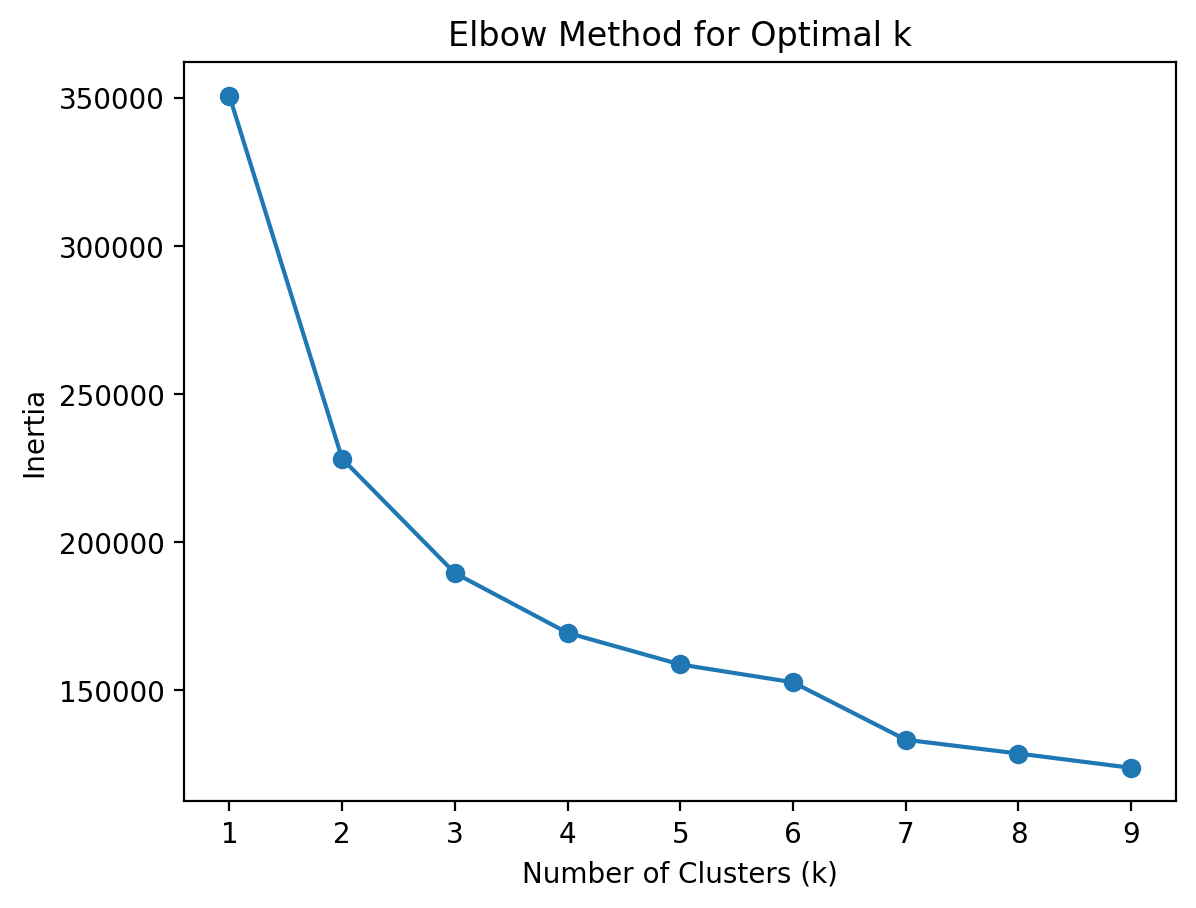

In [10]:
# Elbow method to determine optimal # of clusters
# Use the Elbow Method to determine the optimal number of clusters (k).
# Cluster the data using K-Means and calculate distances from cluster centroid

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

inertia = []
k_range = range(1, 10)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()


Silhouette Score for k=2: 0.3138377736201252
Silhouette Score for k=3: 0.21262895281209712
Silhouette Score for k=4: 0.21608566456884848
Silhouette Score for k=5: 0.1448993091339406
Silhouette Score for k=6: 0.13110660330848992
Silhouette Score for k=7: 0.15726734936650205
Silhouette Score for k=8: 0.12990623716065464
Silhouette Score for k=9: 0.12541571900036524


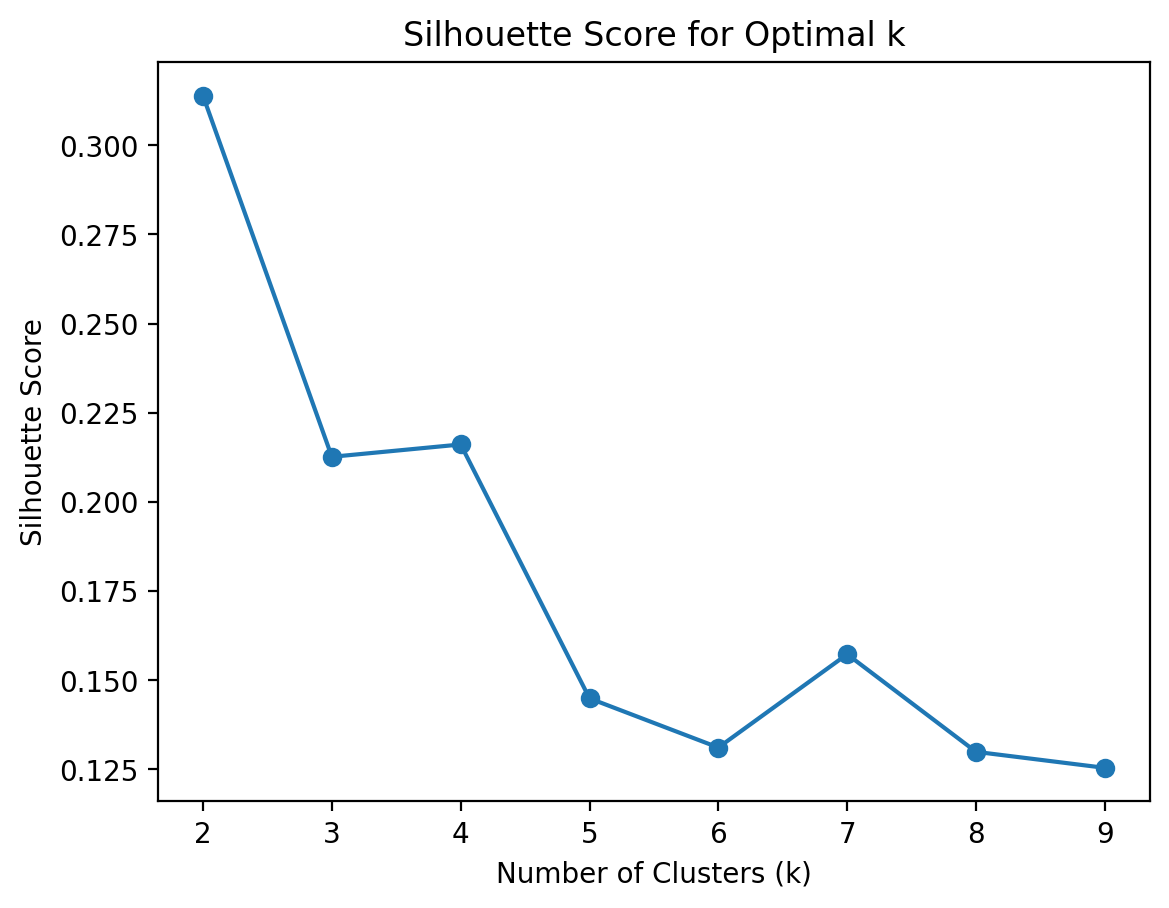

In [11]:
# Silhouette Score to determine # of clusters
# Measures how well-separated the clusters are.
# Higher silhouette scores indicate better-defined clusters

from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

silhouette_scores = []
k_range = range(2, 10)  # Test for k values from 2 to 9

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)  # X_scaled: your preprocessed dataset
    score = silhouette_score(X_scaled, kmeans.labels_)
    silhouette_scores.append(score)
    print(f"Silhouette Score for k={k}: {score}")

# Plot the silhouette scores
plt.plot(k_range, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal k')
plt.show()


Rationale for 𝑘=3

## Interpretability:

k=3 aligns well with the hypothesis of three operational states:

- Normal: Data points representing expected behavior.
- Degraded: Slight deviations from normal that could signal early warnings.
- Anomalous: Clear outliers far from normal behavior.

## Elbow Method:

- The elbow plot shows a significant reduction in inertia at 
k=3, making it a reasonable choice from a compactness perspective.
Silhouette Score:

## While the silhouette score for 

- k=3 (0.1436) is not the highest, it is still reasonably close to 
k=4 and provides a balance between interpretability and data representation.

## Operational Context:

k=3 allows for a meaningful segmentation of the data into actionable categories:
- Normal: No action required.
- Degraded: Investigate or monitor closely.
- Anomalous: Immediate attention needed.


In [12]:
# Fit K-Means with the optimal number of clusters
optimal_k = 3  # Hypothesized states: normal, degraded, and anomalous
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(X_scaled)

KMeans(n_clusters=3, random_state=42)

# Anomaly Detection

- Compute distances of each data point to its cluster centroid.
- Define a threshold for anomalies (e.g., points in the top 5% of distances are anomalies).

In [13]:
# Compute distances to cluster centroids
distances = kmeans.transform(X_scaled).min(axis=1)

# Define anomaly threshold (e.g., top 5% of distances)
threshold = np.percentile(distances, 95)
df_train['anomaly'] = distances > threshold

# Count anomalies
anomaly_count = df_train['anomaly'].sum()
print(f"Number of anomalies detected: {anomaly_count}")


Number of anomalies detected: 1032


# Visualize Clusters and Anomalies

- Reduce the dimensionality of the data to 2D using PCA or t-SNE for visualization.
- Plot clusters and highlight anomalies.

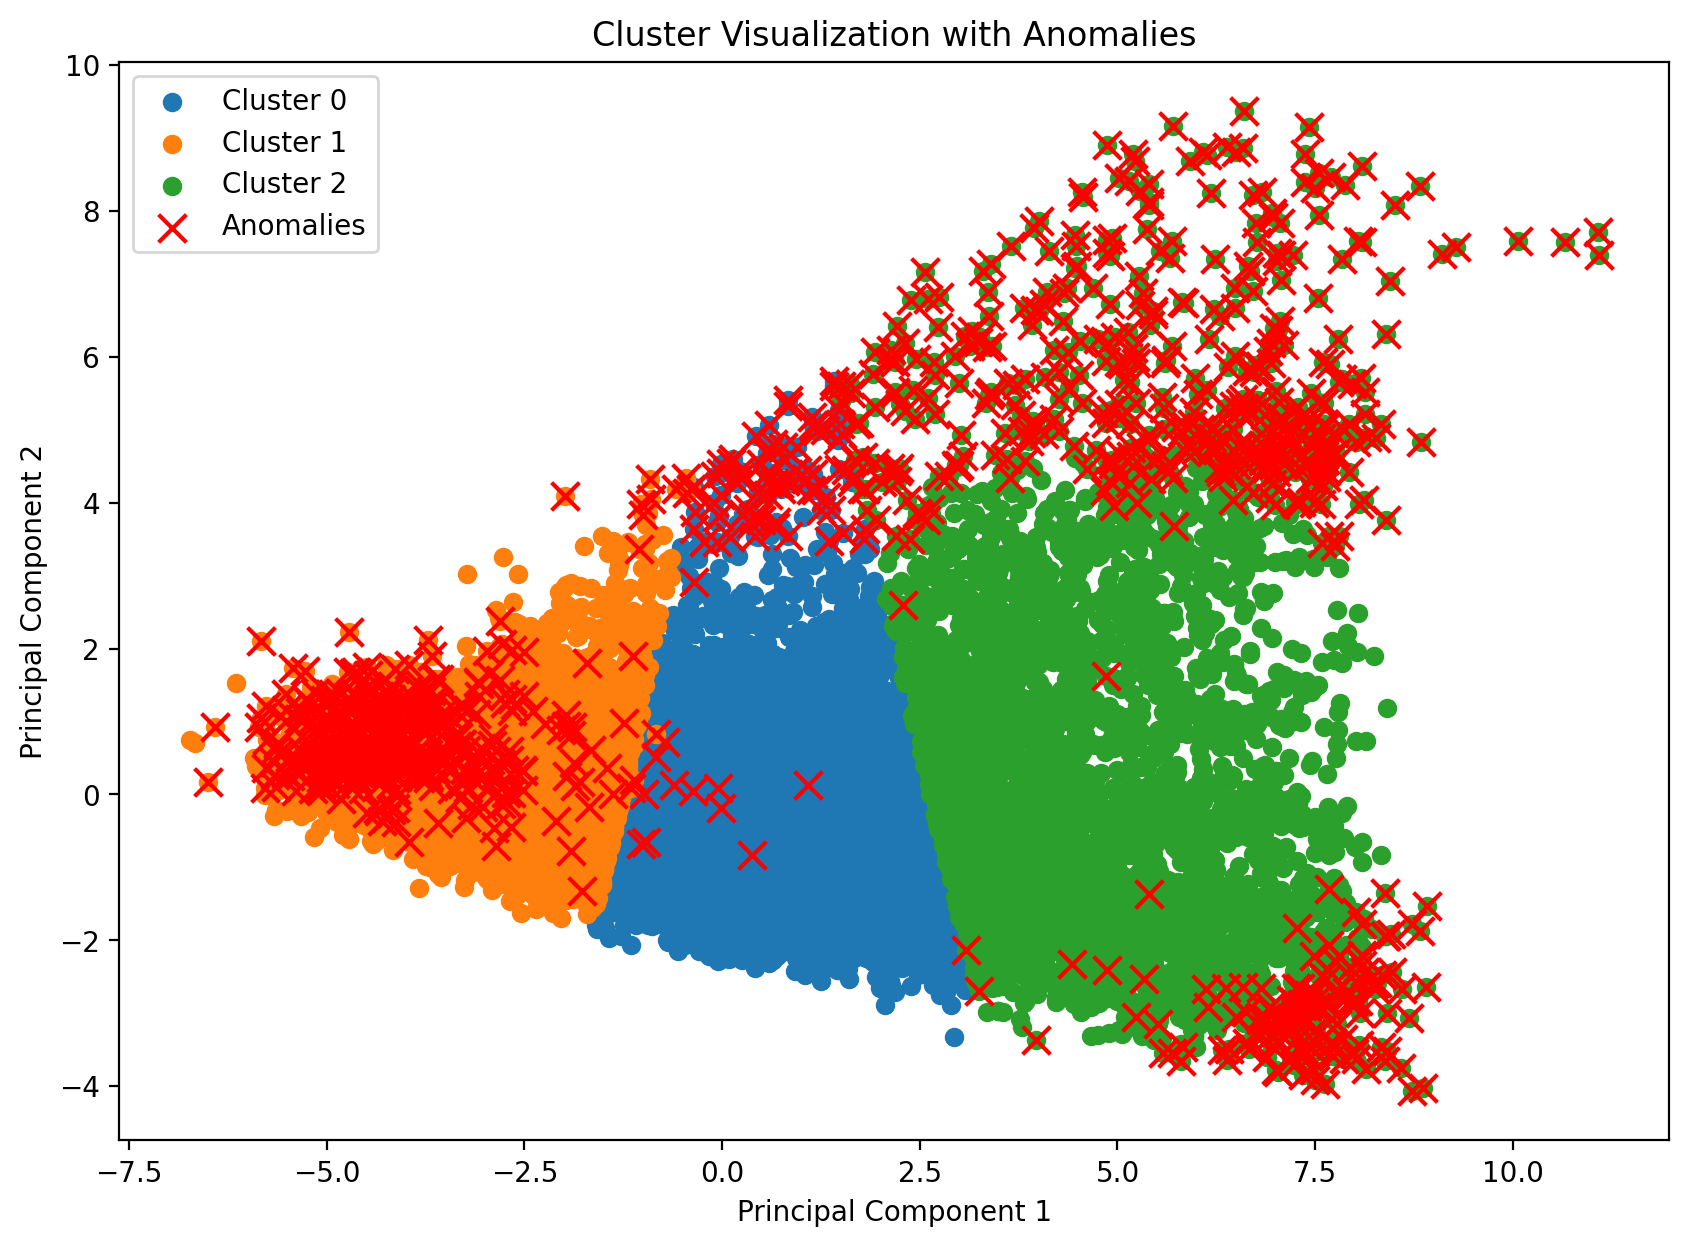

In [14]:
from sklearn.decomposition import PCA

# Reduce to 2D for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Visualize clusters
plt.figure(figsize=(10, 7))
for cluster in range(optimal_k):
    plt.scatter(
        X_pca[kmeans.labels_ == cluster, 0],
        X_pca[kmeans.labels_ == cluster, 1],
        label=f'Cluster {cluster}'
    )

# Highlight anomalies
plt.scatter(
    X_pca[df_train['anomaly'], 0],
    X_pca[df_train['anomaly'], 1],
    color='red',
    label='Anomalies',
    marker='x',
    s=100
)

plt.title('Cluster Visualization with Anomalies')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()


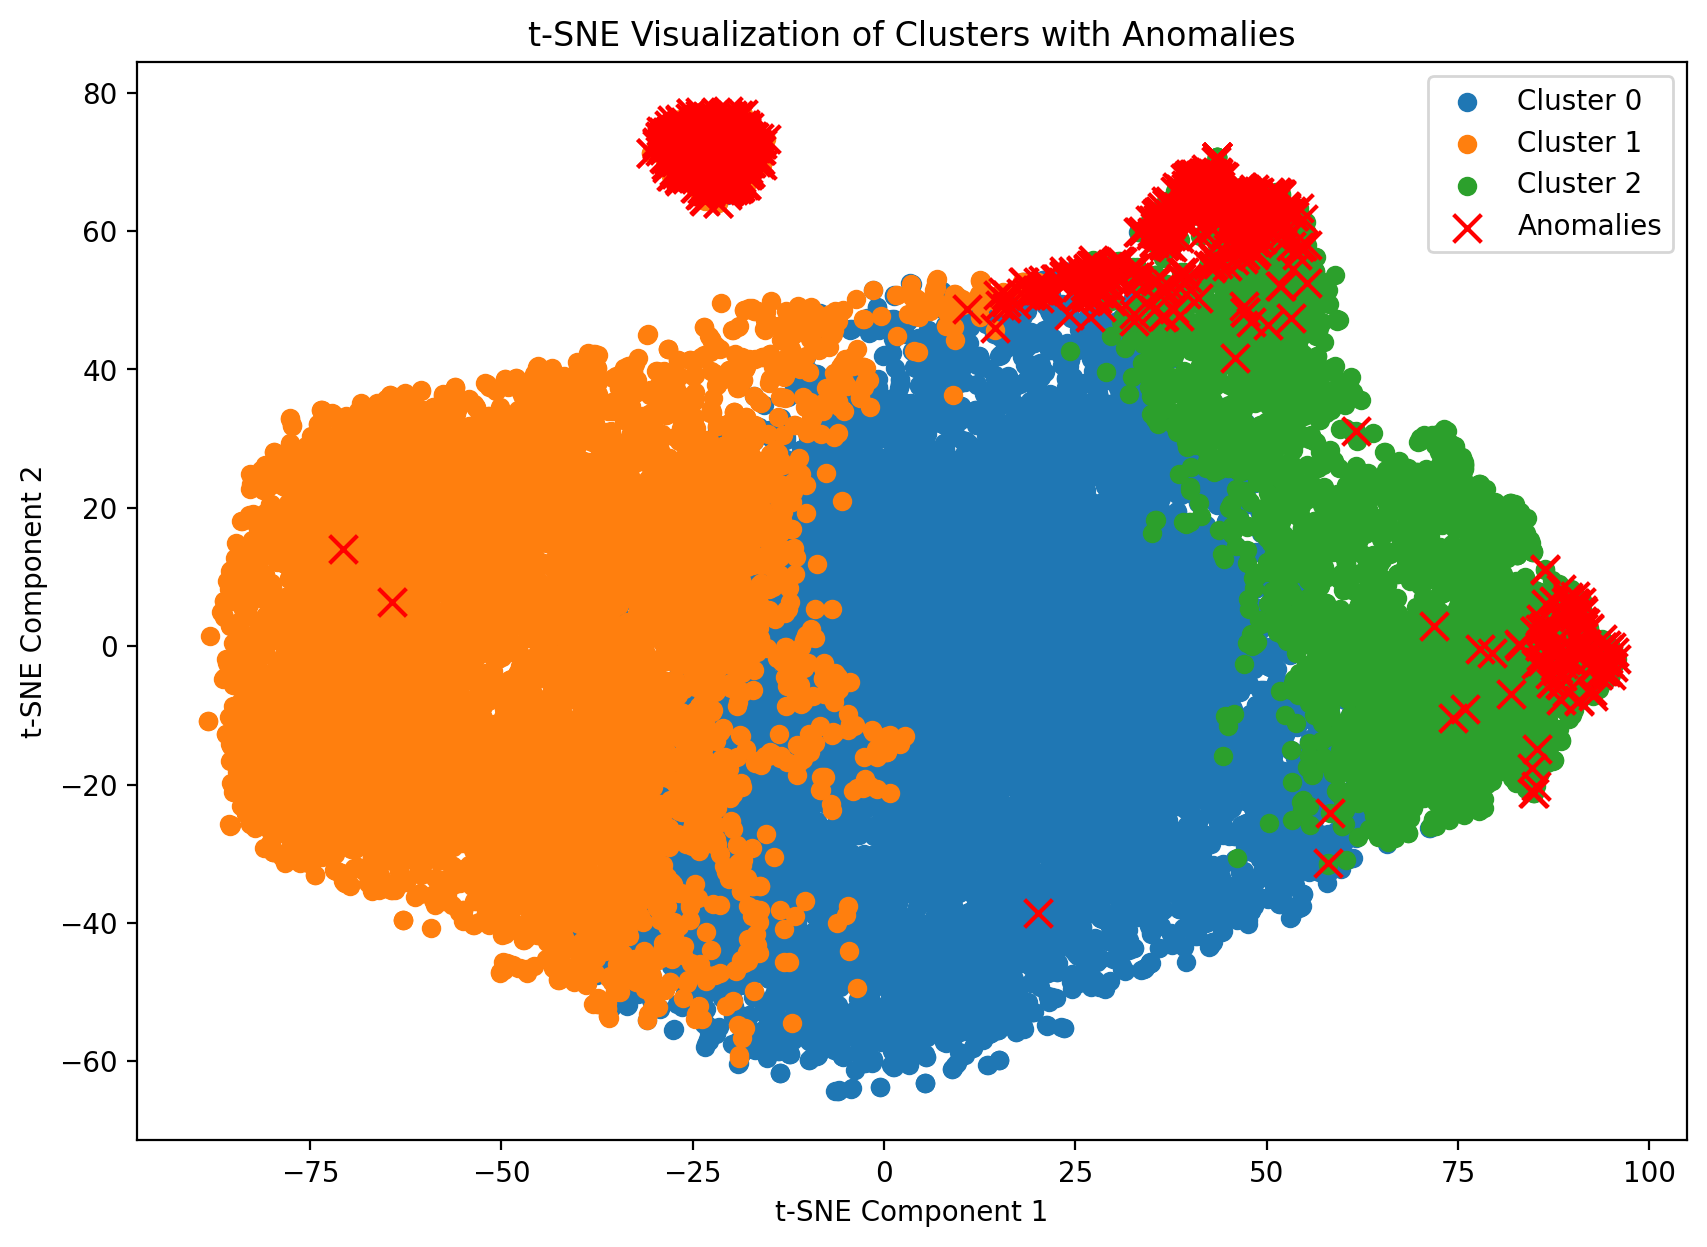

In [15]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Reduce data to 2D using t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

# Visualize clusters
plt.figure(figsize=(10, 7))
for cluster in range(optimal_k):
    plt.scatter(
        X_tsne[kmeans.labels_ == cluster, 0],
        X_tsne[kmeans.labels_ == cluster, 1],
        label=f'Cluster {cluster}'
    )

# Highlight anomalies
plt.scatter(
    X_tsne[df_train['anomaly'], 0],
    X_tsne[df_train['anomaly'], 1],
    color='red',
    label='Anomalies',
    marker='x',
    s=100
)

# Plot details
plt.title('t-SNE Visualization of Clusters with Anomalies')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.show()


Anomalies:

Both PCA and t-SNE confirm that anomalies are primarily located on the fringes or outside the main clusters.
t-SNE provides a more distinct separation of anomalies from the main clusters, making it a preferred choice for anomaly visualization.

# Analyze Anomalies

## Explanation of the Code
- mean_diff calculates the mean difference between anomalies and normal data for each feature.
- The abs() function is used to sort features by the magnitude of the difference.
- Only the top 10 features are displayed to focus on the most impactful variables.
- Use Results for Monitoring:

Highlight the top features contributing to anomalies for operational monitoring and alert systems.

In [16]:
# Define anomalies and normal data subsets
anomalies = df_train[df_train['anomaly'] == True]
normal_data = df_train[df_train['anomaly'] == False]

# Compute mean differences
anomaly_summary = anomalies.mean()  # Mean of each feature for anomalies
normal_summary = normal_data.mean()  # Mean of each feature for normal data
mean_diff = anomaly_summary - normal_summary  # Calculate differences

# Sort features by the magnitude of the difference
sorted_diff = mean_diff.abs().sort_values(ascending=False)

# Display the top features contributing to anomalies
print("Top features contributing to anomalies:")
print(mean_diff[sorted_diff.index[:10]])


Top features contributing to anomalies:
(Physical core speed) (rpm)                39.968589
(Corrected core speed) (rpm)               34.285845
cycle                                      33.214029
engine                                     -6.831836
(LPT outlet temperature) (◦R)               5.133479
(HPC outlet temperature) (◦R)               3.892533
anomaly                                     1.000000
(Bleed Enthalpy)                            0.980852
(HPC outlet pressure) (psia)               -0.348445
(Ratio of fuel flow to Ps30) (pps/psia)    -0.283780
dtype: float64


In [17]:
# Add cluster labels to the dataset
df_train['cluster'] = kmeans.labels_

# Calculate summary statistics for each cluster
cluster_summary = df_train.groupby('cluster').mean()

print("Cluster characteristics:")
print(cluster_summary)


Cluster characteristics:
            engine       cycle  setting_1  setting_2  setting_3  (Fan inlet temperature) (◦R)  (LPC outlet temperature) (◦R)  (HPC outlet temperature) (◦R)  (LPT outlet temperature) (◦R)  (Fan inlet Pressure) (psia)  (bypass-duct pressure) (psia)  (HPC outlet pressure) (psia)  (Physical fan speed) (rpm)  (Physical core speed) (rpm)  (Engine pressure ratio(P50/P2)  (HPC outlet Static pressure) (psia)  (Ratio of fuel flow to Ps30) (pps/psia)  (Corrected fan speed) (rpm)  (Corrected core speed) (rpm)  (Bypass Ratio)   (Burner fuel-air ratio)  (Bleed Enthalpy)  (Required fan speed)  (Required fan conversion speed)  (High-pressure turbines Cool air flow)  (Low-pressure turbines Cool air flow)   anomaly
cluster                                                                                                                                                                                                                                                                     

In [18]:
# Calculate feature differences between clusters
cluster_diff = cluster_summary.max() - cluster_summary.min()

# Sort features by their differences
significant_features = cluster_diff.sort_values(ascending=False)
print("Top features contributing to cluster differences:")
print(significant_features.head(10))


Top features contributing to cluster differences:
cycle                                      123.482542
(Physical core speed) (rpm)                 23.748965
(LPT outlet temperature) (◦R)               21.122872
(Corrected core speed) (rpm)                17.590162
(HPC outlet temperature) (◦R)               12.498704
(Bleed Enthalpy)                             3.259222
(HPC outlet pressure) (psia)                 2.047702
(Ratio of fuel flow to Ps30) (pps/psia)      1.741156
(LPC outlet temperature) (◦R)                1.060238
engine                                       1.001947
dtype: float64


Expected Output:

Bar plots showing how the mean value of each feature varies by cluster.

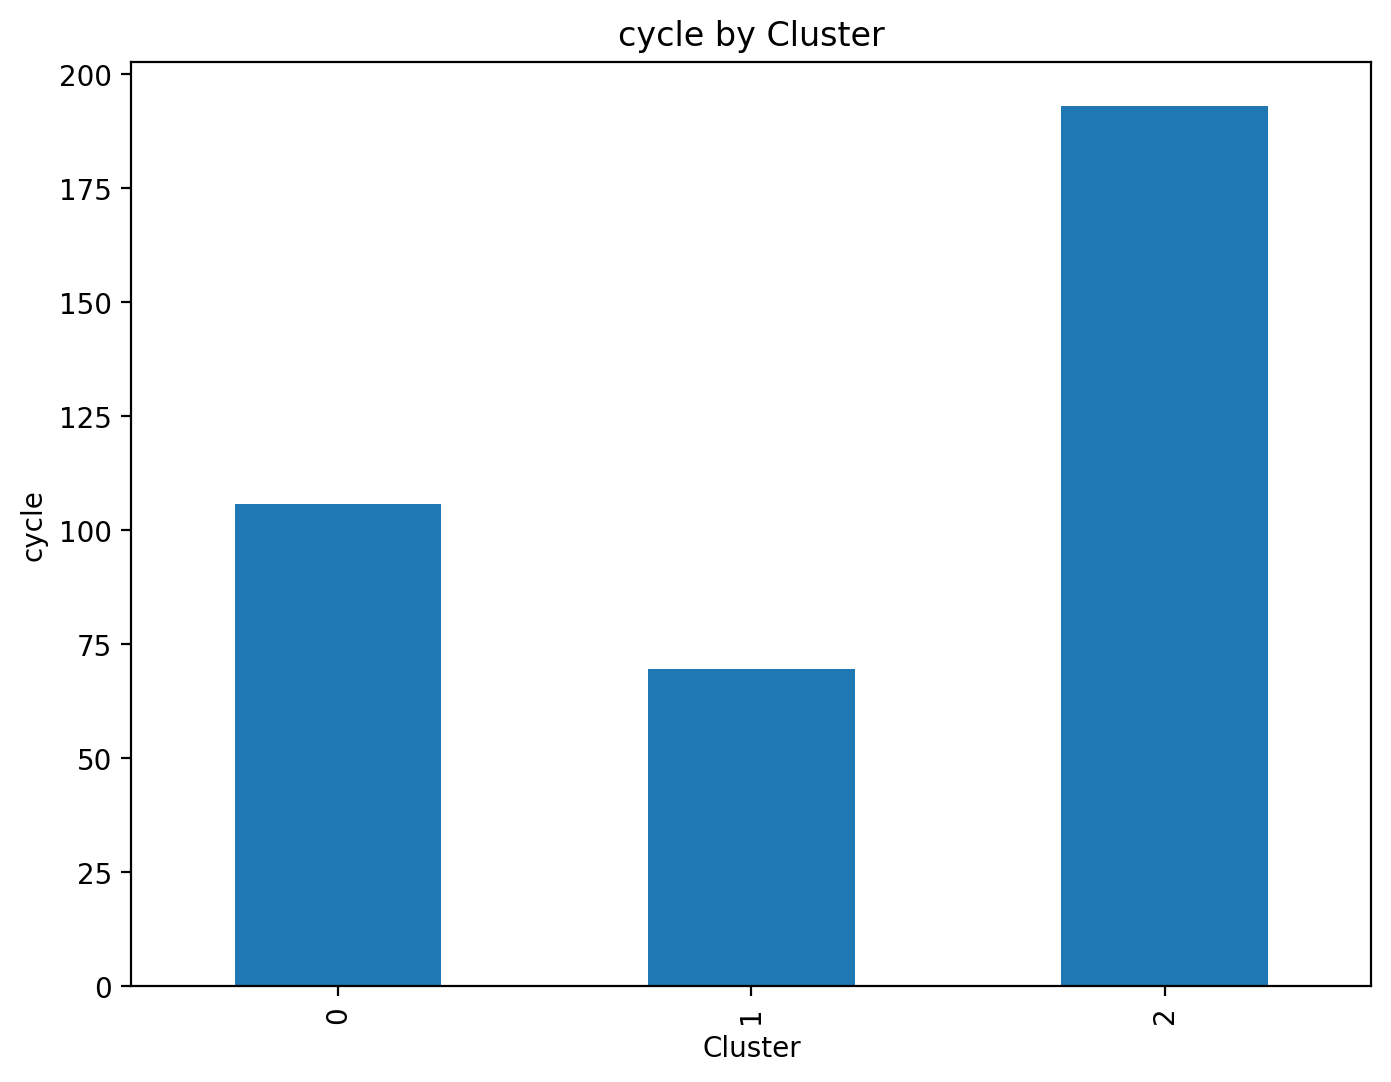

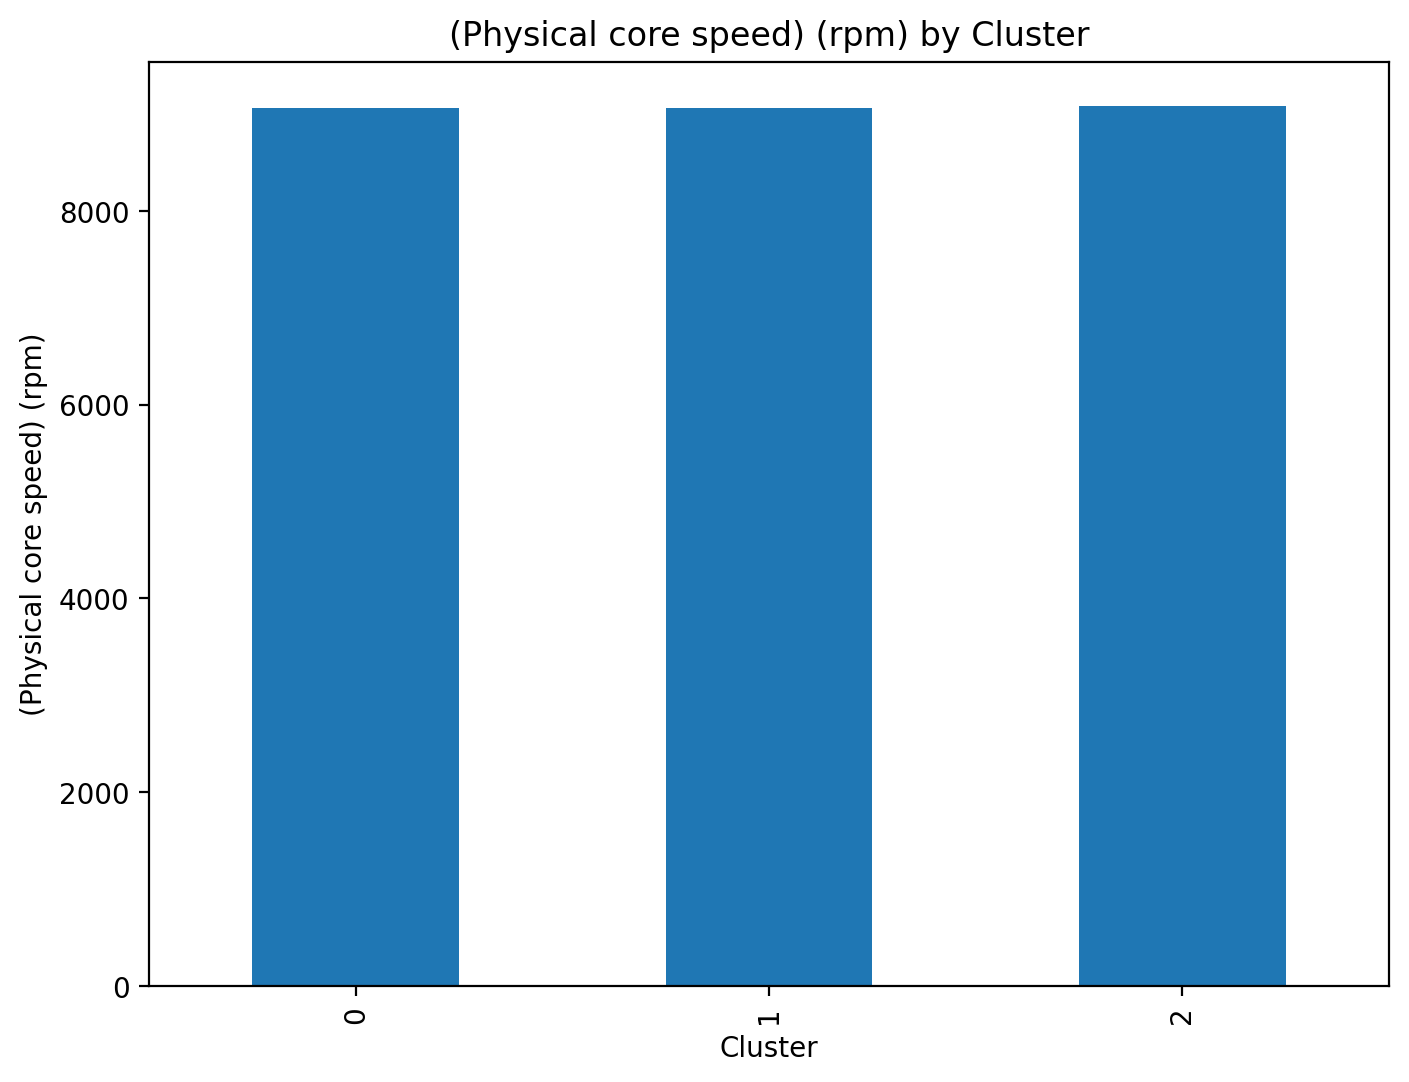

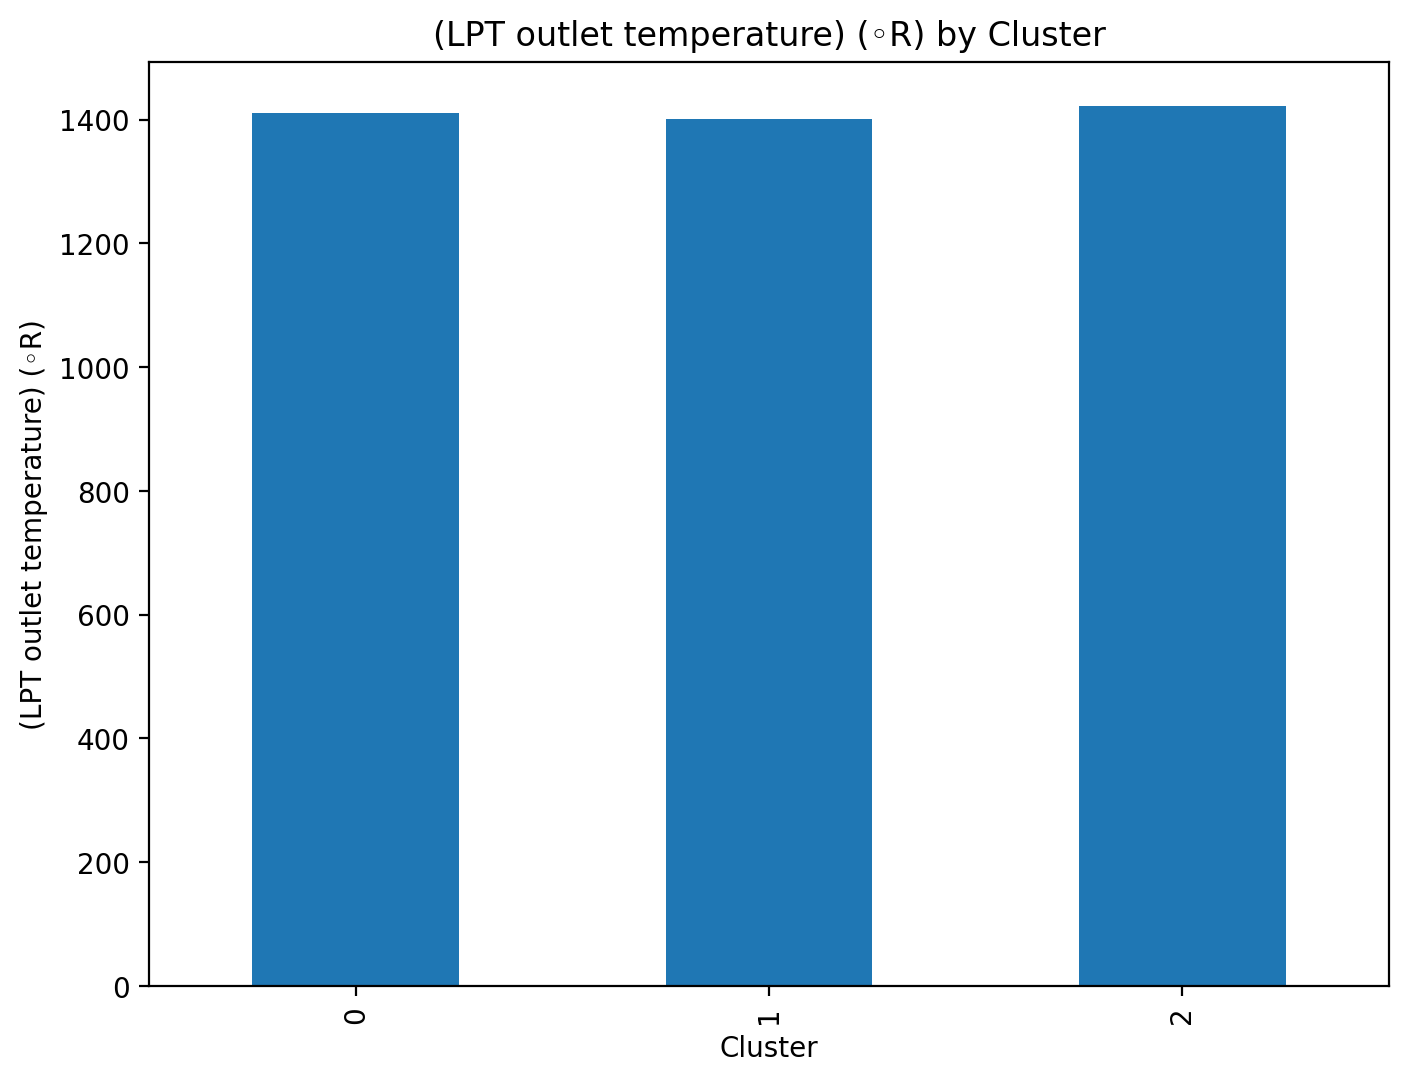

In [ ]:
import matplotlib.pyplot as plt

# Select top 3 features for visualization
top_features = significant_features.index[:3]

for feature in top_features:
    cluster_summary[feature].plot(kind='bar', figsize=(8, 6), title=f'{feature} by Cluster')
    plt.xlabel('Cluster')
    plt.ylabel(feature)
    plt.show()

Graph 1: cycle by Cluster
Observation:

Cluster 2 has the highest average cycle values, around 200.
Cluster 1 has the lowest average cycle values, around 70.
Cluster 0 has intermediate average cycle values, around 105.
Interpretation:

Cluster 1 likely represents engines in earlier stages of their operational lifecycle (low cycles).
Cluster 2 represents engines nearing the end of their lifecycle, which might correspond to degraded states or engines closer to failure.
Cluster 0 represents engines in the middle stages of their lifecycle.
Graph 2: (Physical core speed) (rpm) by Cluster
Observation:

The average physical core speed is relatively consistent across clusters, with values around 8,000 rpm.
No significant differences between clusters are visible in this feature.
Interpretation:

Core speed does not appear to play a significant role in differentiating the clusters.
It may still contribute to anomalies or be more relevant when combined with other features (e.g., temperatures or pressures).
Graph 3: (LPT outlet temperature) (◦R) by Cluster
Observation:

The average low-pressure turbine outlet temperature is consistent across all clusters, hovering around 1,400◦R.
Interpretation:

Similar to core speed, (LPT outlet temperature) is not a distinguishing feature for the clusters.
However, it may contribute to understanding engine conditions when anomalies are overlaid on the clusters.

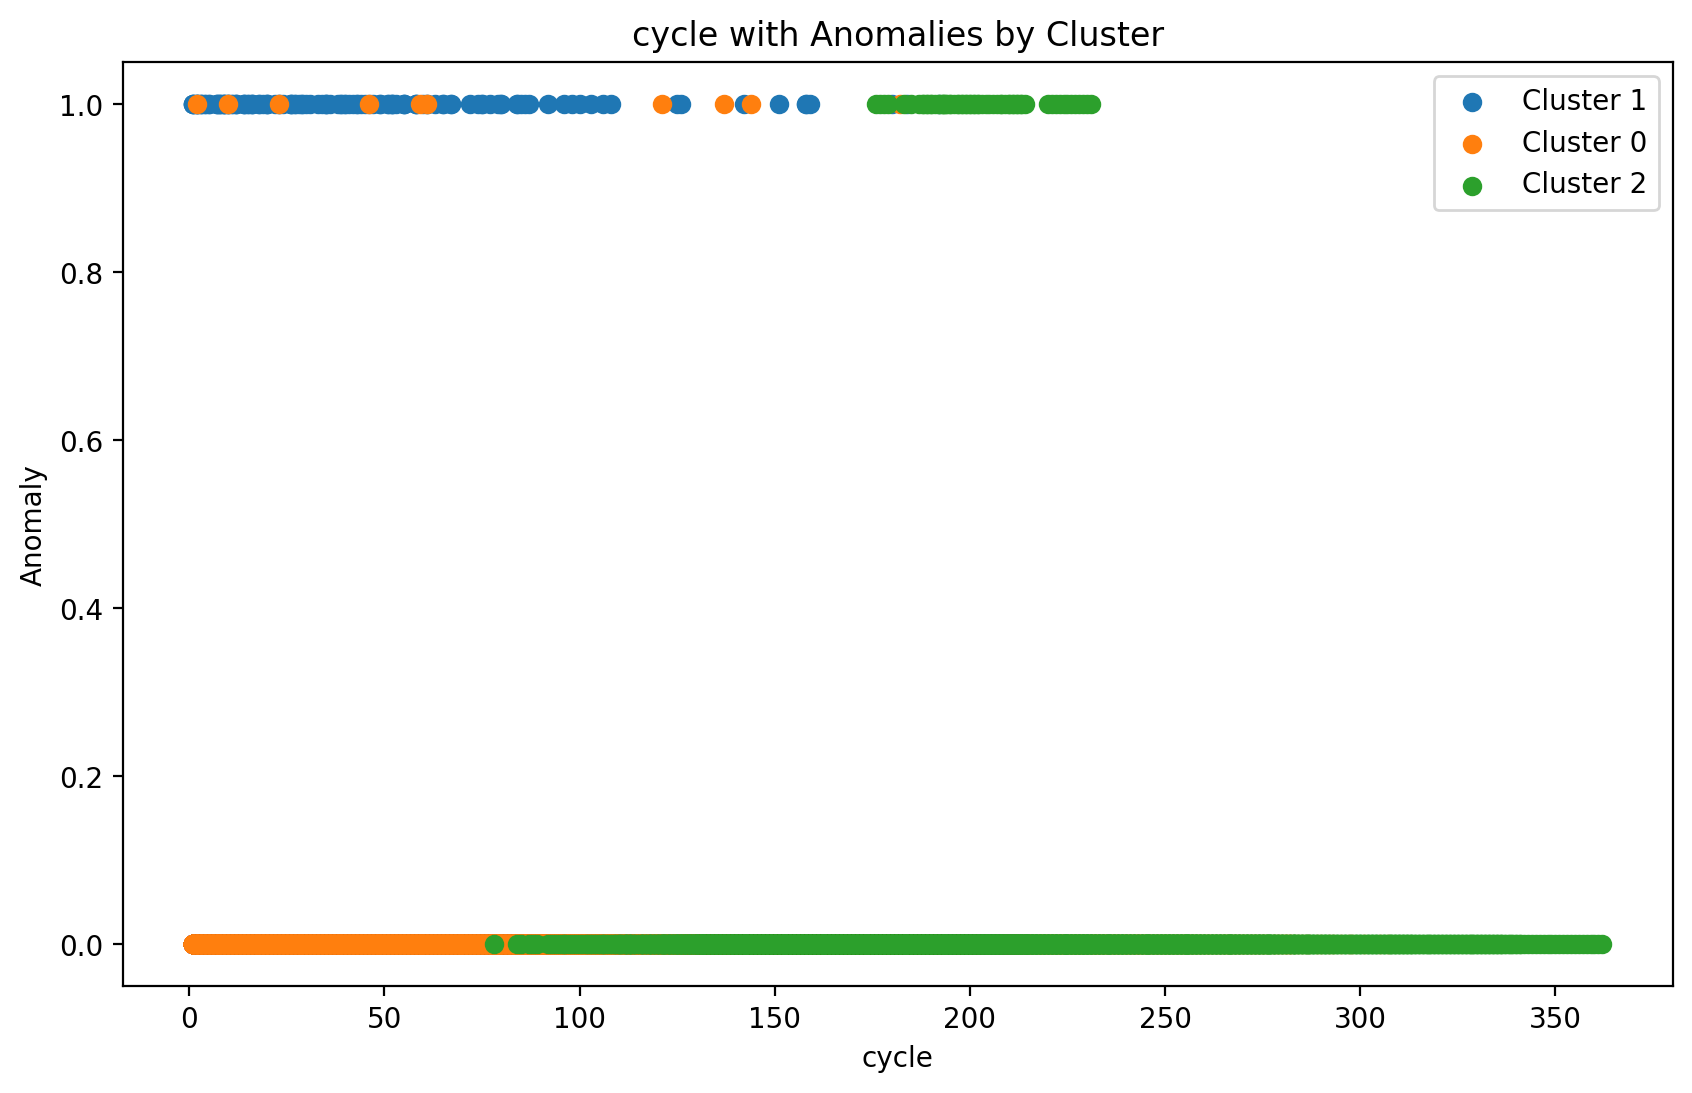

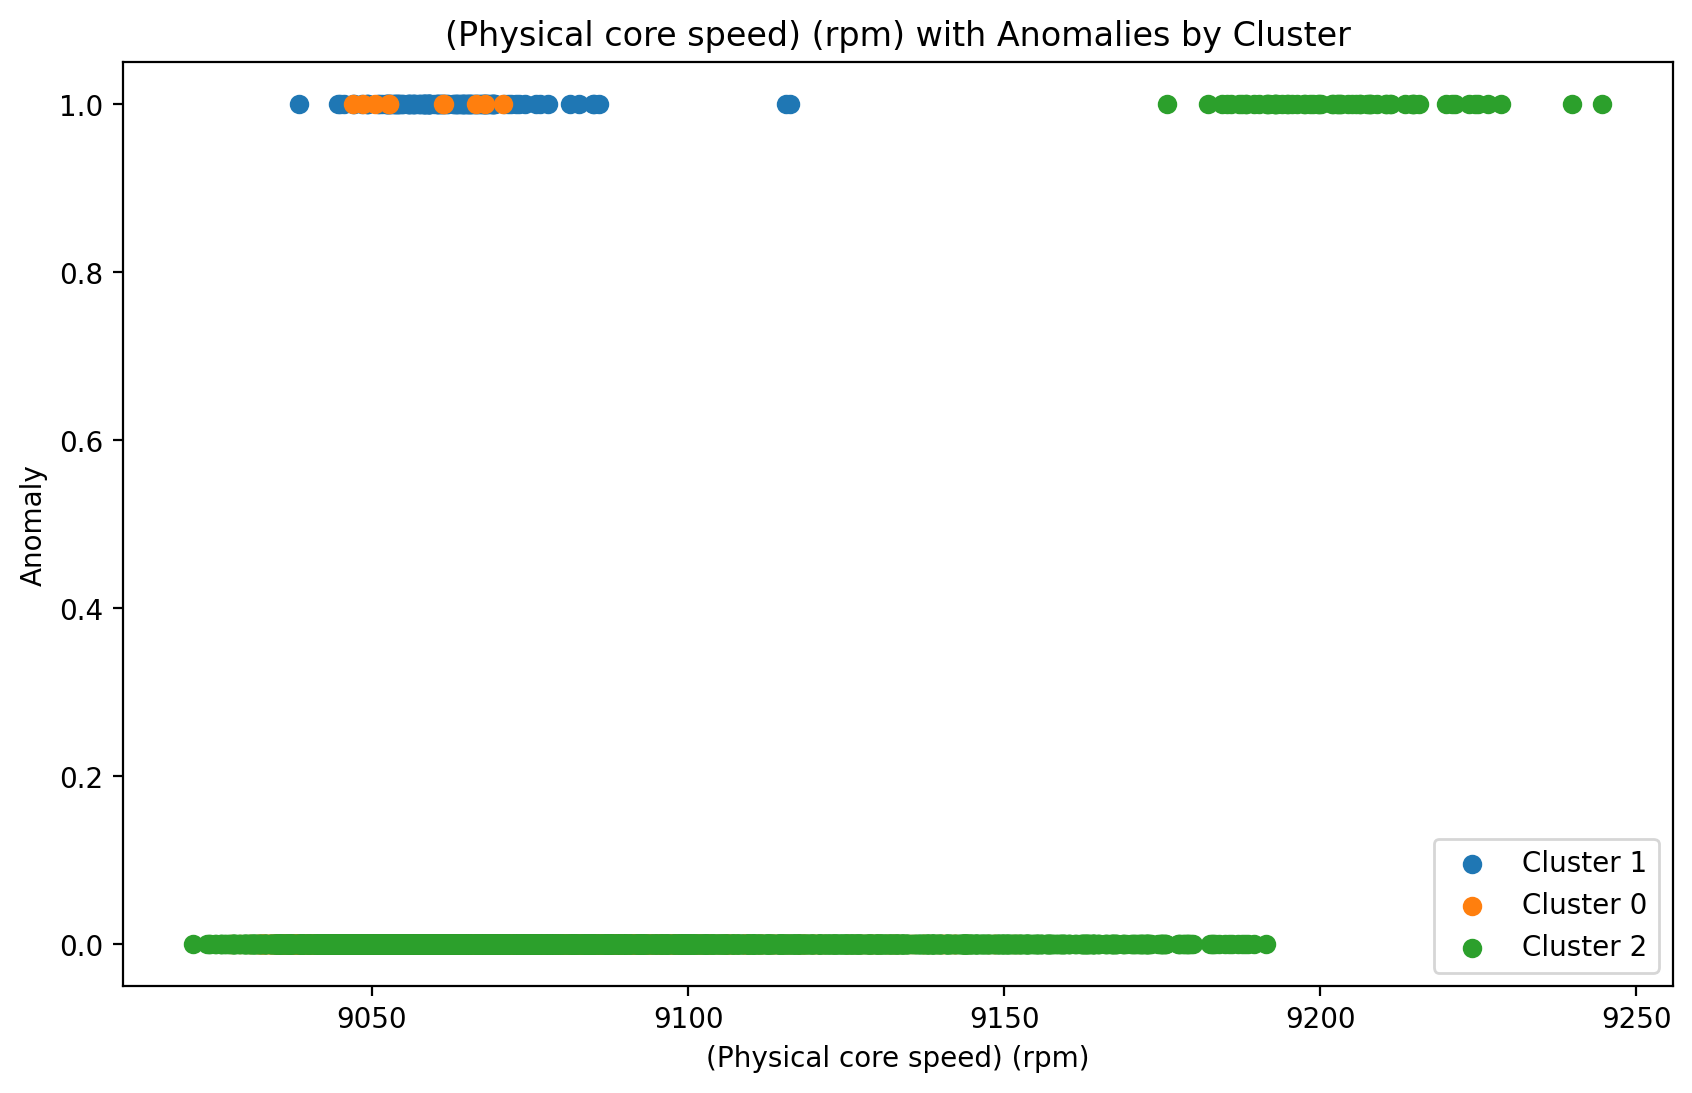

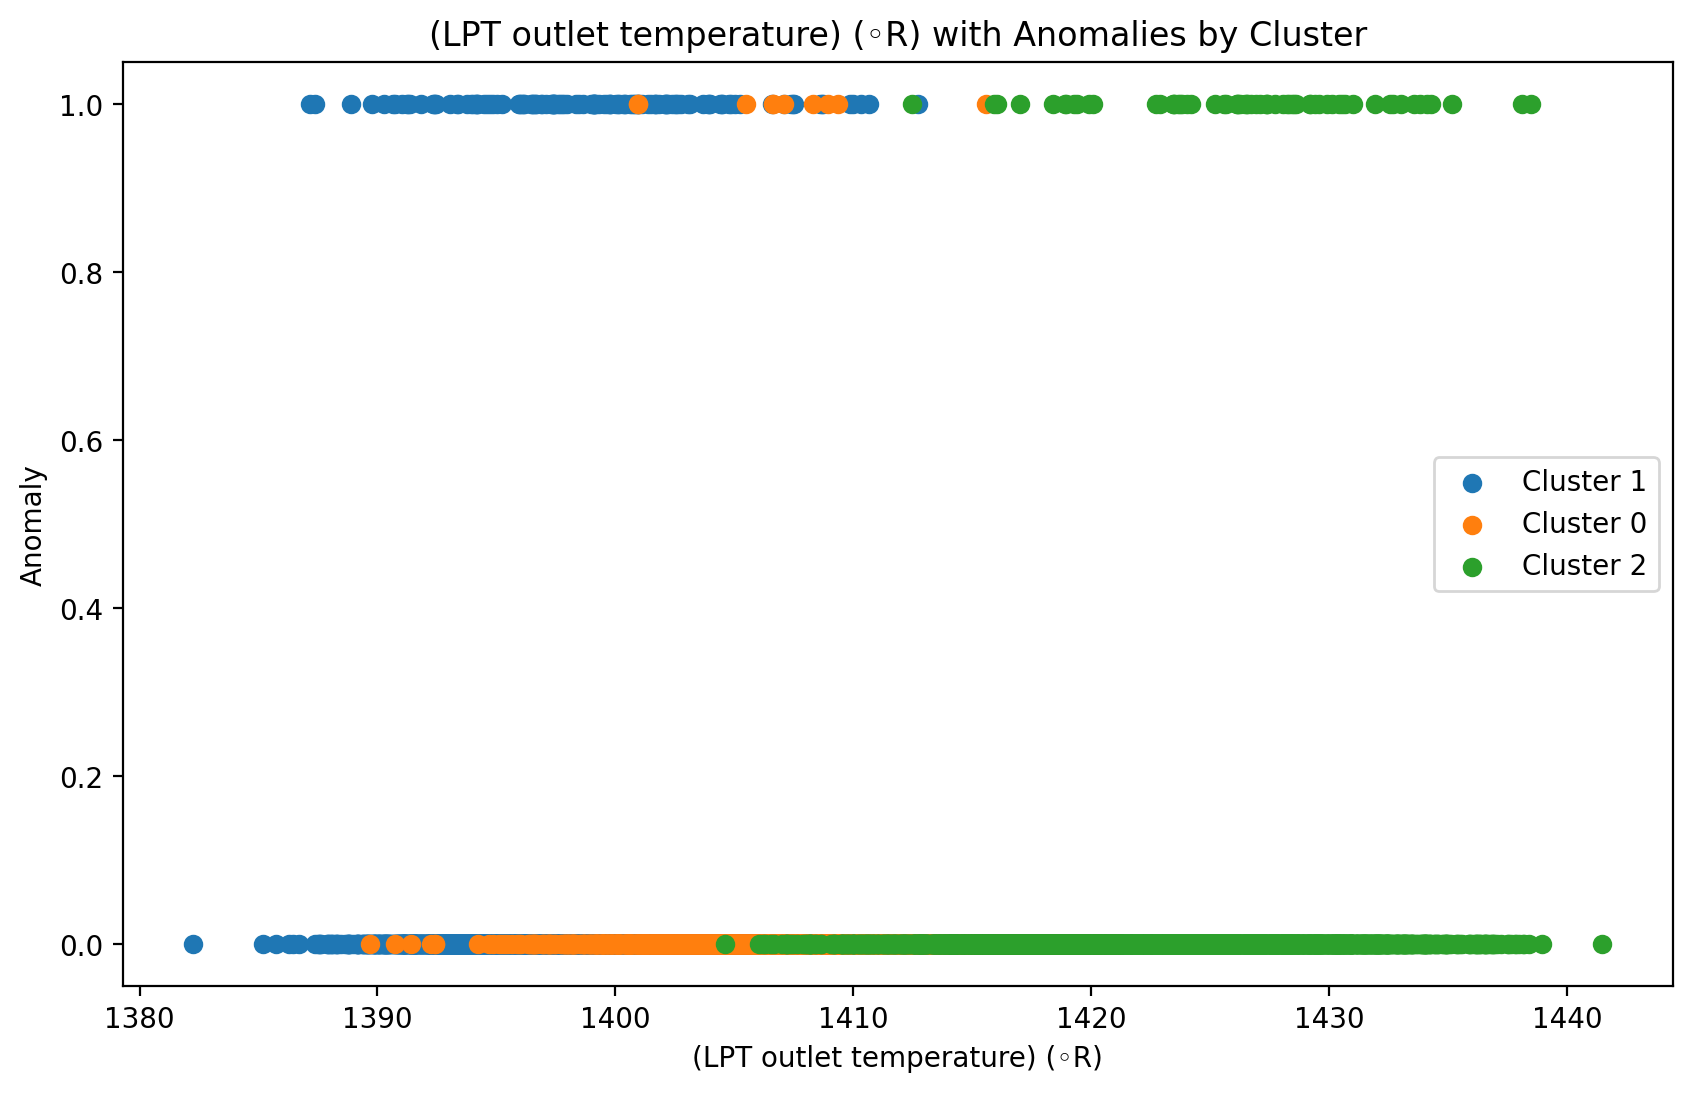

In [25]:
for feature in ['cycle', '(Physical core speed) (rpm)', '(LPT outlet temperature) (◦R)']:
    plt.figure(figsize=(10, 6))
    for cluster in df_train['cluster'].unique():
        cluster_data = df_train[df_train['cluster'] == cluster]
        plt.scatter(cluster_data[feature], cluster_data['anomaly'], label=f'Cluster {cluster}')
    plt.title(f'{feature} with Anomalies by Cluster')
    plt.xlabel(feature)
    plt.ylabel('Anomaly')
    plt.legend()
    plt.show()


# Visualize Sensor Trends
- Use time-series plots to see how anomalies and clusters evolve over time (cycle).

## What to Look For
- Do anomalies appear near the end of an engine’s lifecycle?
- Are there sudden spikes or trends in specific sensors for anomalies?

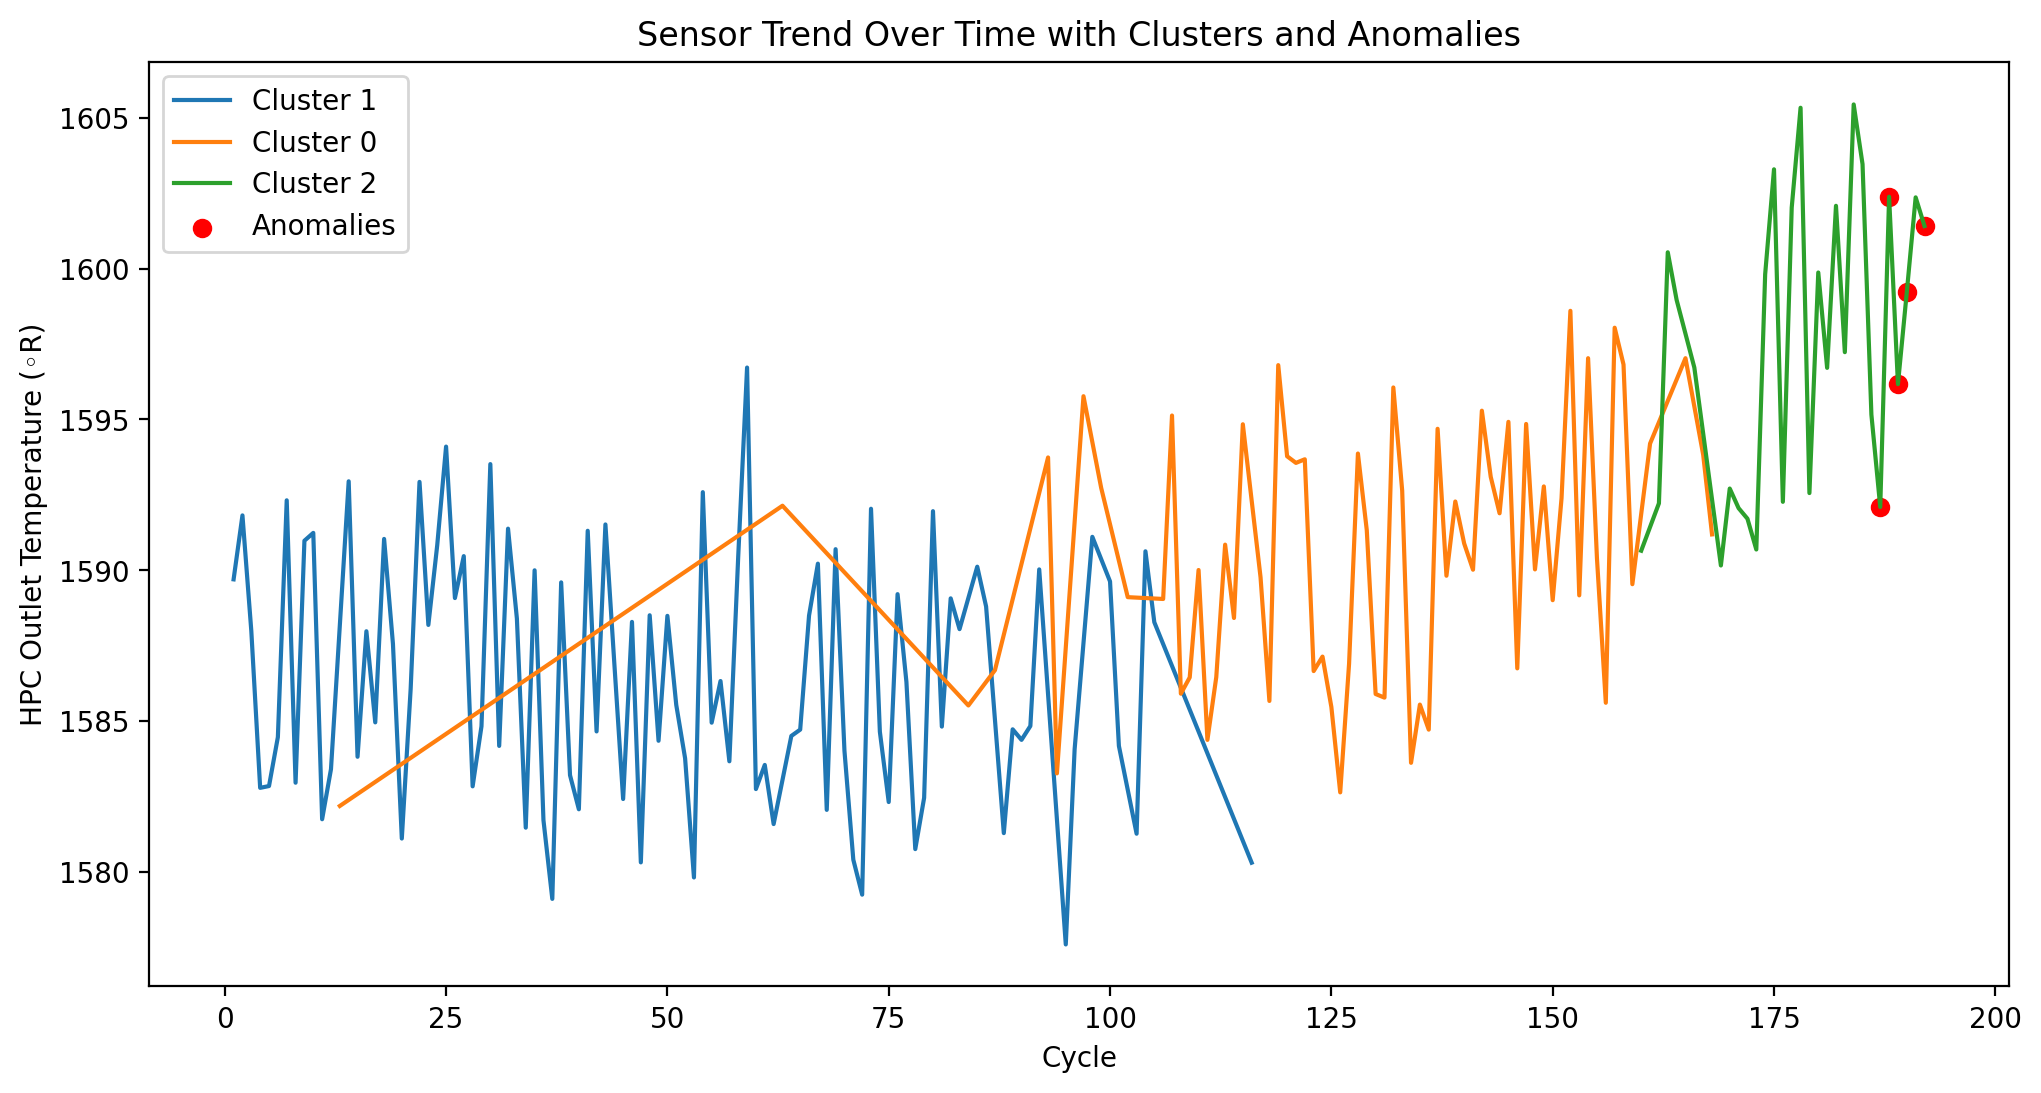

In [20]:
# import matplotlib.pyplot as plt

# Plot a specific sensor over time for a sample engine
engine_id = 1
sample_data = df_train[df_train['engine'] == engine_id]

plt.figure(figsize=(12, 6))
for cluster in df_train['cluster'].unique():
    cluster_data = sample_data[sample_data['cluster'] == cluster]
    plt.plot(cluster_data['cycle'], cluster_data['(HPC outlet temperature) (◦R)'], label=f'Cluster {cluster}')

# Highlight anomalies
anomaly_data = sample_data[sample_data['anomaly'] == True]
plt.scatter(anomaly_data['cycle'], anomaly_data['(HPC outlet temperature) (◦R)'], color='red', label='Anomalies')

plt.xlabel('Cycle')
plt.ylabel('HPC Outlet Temperature (◦R)')
plt.title('Sensor Trend Over Time with Clusters and Anomalies')
plt.legend()
plt.show()


# Validate Anomalies
- Compare anomalies to domain knowledge or use the provided Remaining Useful Life (RUL) data to check if anomalies correlate with near-failure conditions.

## What to Look For
- Do anomalies have lower RUL (closer to failure) compared to normal data?
- Are anomalies concentrated in specific lifecycle stages?

In [21]:
# Merge test RUL data to anomalies (if applicable)
df_anomalies_with_rul = anomalies.merge(df_test_RUL, left_on='engine', right_index=True)

# Compare RUL for anomalies vs. normal data
print("Anomaly RUL summary:")
print(df_anomalies_with_rul['RUL'].describe())
print("Normal data RUL summary:")
print(normal_data.merge(df_test_RUL, left_on='engine', right_index=True)['RUL'].describe())


Anomaly RUL summary:
count    1030.000000
mean       72.495146
std        41.901030
min         7.000000
25%        29.000000
50%        82.000000
75%        98.000000
max       145.000000
Name: RUL, dtype: float64
Normal data RUL summary:
count    19401.000000
mean        76.662234
std         41.357007
min          7.000000
25%         37.000000
50%         87.000000
75%        113.000000
max        145.000000
Name: RUL, dtype: float64


# Feature Importance for Anomalies
- Use a simple classification model (e.g., Random Forest) to identify which features contribute the most to anomalies.

## What to Look For
- Which features (sensor readings, settings) contribute the most to anomalies?
- Use this insight to focus on key variables for monitoring and predictive maintenance.


# Area Under the Curve (AUC-ROC)

- The AUC-ROC score evaluates the classifier's ability to separate anomalies from normal data across all possible thresholds.

In [23]:
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_train)


# Train a Random Forest to classify anomalies
clf = RandomForestClassifier(random_state=42)
clf.fit(X_scaled, df_train['anomaly'])

# Get feature importance
feature_importance = pd.Series(clf.feature_importances_, index=selected_columns).sort_values(ascending=False)

print("Top features contributing to anomalies:")
print(feature_importance.head(10))


Top features contributing to anomalies:
(bypass-duct pressure) (psia)            0.352159
(Corrected core speed) (rpm)             0.206926
(Physical core speed) (rpm)              0.163701
(Corrected fan speed) (rpm)              0.034754
(Physical fan speed) (rpm)               0.029102
(HPC outlet Static pressure) (psia)      0.025366
(HPC outlet temperature) (◦R)            0.024063
(LPT outlet temperature) (◦R)            0.021256
(HPC outlet pressure) (psia)             0.020350
(Low-pressure turbines Cool air flow)    0.020086
dtype: float64


In [28]:
#A higher AUC-ROC score (closer to 1.0) indicates a better-performing model.

from sklearn.metrics import roc_auc_score

# Predicted probabilities
y_probs = clf.predict_proba(X_scaled)[:, 1]

# AUC-ROC score
auc_score = roc_auc_score(df_train['anomaly'], y_probs)
print(f"AUC-ROC Score: {auc_score}")


AUC-ROC Score: 0.9851271403728872


# F1-Score

- F1-Score balances precision and recall, providing a single metric for model performance in imbalanced datasets (which is typical in anomaly detection).
- A higher F1-Score indicates a good balance between precision and recall.

In [32]:
from sklearn.metrics import f1_score

# Generate predictions
y_pred = clf.predict(X_scaled)

# Calculate F1-Score
f1 = f1_score(df_train['anomaly'], y_pred)
print(f"F1-Score: {f1}")


F1-Score: 0.3341404358353511


# Reduction in False Positives
- Anomaly detection systems are often evaluated based on how well they reduce false alarms (false positives).
- Lower FPR values indicate fewer false alarms, making the model more practical for deployment.

In [33]:
from sklearn.metrics import confusion_matrix

# Confusion Matrix
tn, fp, fn, tp = confusion_matrix(df_train['anomaly'], y_pred).ravel()
fpr = fp / (fp + tn)
print(f"False Positive Rate: {fpr}")


False Positive Rate: 0.04039365452408931


#  Model Interpretability Metrics
- Use the feature_importance from the Random Forest to track the stability of the top features over time or iterations.

In [31]:
print("Top features contributing to anomalies:")
print(feature_importance.head(10))


Top features contributing to anomalies:
(bypass-duct pressure) (psia)            0.352159
(Corrected core speed) (rpm)             0.206926
(Physical core speed) (rpm)              0.163701
(Corrected fan speed) (rpm)              0.034754
(Physical fan speed) (rpm)               0.029102
(HPC outlet Static pressure) (psia)      0.025366
(HPC outlet temperature) (◦R)            0.024063
(LPT outlet temperature) (◦R)            0.021256
(HPC outlet pressure) (psia)             0.020350
(Low-pressure turbines Cool air flow)    0.020086
dtype: float64


In [34]:
# Evaluate other metrics

from sklearn.metrics import precision_score, recall_score, confusion_matrix

# Calculate additional metrics
precision = precision_score(df_train['anomaly'], y_pred)
recall = recall_score(df_train['anomaly'], y_pred)

# Confusion matrix
tn, fp, fn, tp = confusion_matrix(df_train['anomaly'], y_pred).ravel()

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Confusion Matrix: TN={tn}, FP={fp}, FN={fn}, TP={tp}")


Precision: 0.2005813953488372
Recall: 1.0
Confusion Matrix: TN=19599, FP=825, FN=0, TP=207


# Recommended North Star Metric
- Primary NSM: F1-Score (to balance precision and recall).

- It ensures the model is both accurate (precision) and comprehensive (recall) in detecting anomalies.
Supporting Metrics:

- AUC-ROC Score: To summarize the model's classification ability.
- Feature Importance Insights: To prioritize monitoring and operational focus.
- False Positive Rate (FPR): To measure the practicality of the model in minimizing false alarms.

# Interpretation

1. AUC-ROC Score: 0.985
What it means:
The AUC-ROC score is very high, close to 1, indicating that the model is excellent at separating anomalies from normal data across all possible thresholds.
Implications:
The model is theoretically effective at ranking data points by their likelihood of being anomalies.
However, the chosen decision threshold may need to be adjusted to balance precision and recall.
2. F1-Score: 0.334
What it means:
The F1-Score is relatively low due to the significant imbalance between precision and recall.
This indicates that while the model is excellent at identifying all anomalies (high recall), it struggles to avoid false positives (low precision).
3. False Positive Rate (FPR): 0.040 (4%)
What it means:
4% of the normal data points are being incorrectly classified as anomalies.
Implications:
This is not excessively high, but reducing the FPR further would improve the practicality of the model for real-world use.
Excessive false positives could lead to wasted resources (e.g., unnecessary maintenance checks).
4. Precision: 0.201
What it means:
Out of all the points classified as anomalies, only ~20% are actual anomalies.
Implications:
Precision is quite low, which means the model generates a significant number of false positives.
This makes it harder to trust the anomaly predictions without further validation or threshold tuning.
5. Recall: 1.0
What it means:
The model has perfect recall, capturing all true anomalies (no false negatives).
Implications:
This is excellent, as no anomalies are missed, but the high recall comes at the cost of low precision (high false positives).
6. Confusion Matrix
TN (True Negatives): 19,599
Normal points correctly identified.
FP (False Positives): 825
Normal points incorrectly flagged as anomalies.
FN (False Negatives): 0
Anomalies incorrectly classified as normal (none in this case).
TP (True Positives): 207
Anomalies correctly identified.
Overall Assessment
Strengths:
High AUC-ROC score indicates strong discriminative power.
Perfect recall ensures all anomalies are detected.
Weaknesses:
Low precision indicates too many false positives, which could reduce the model's practicality in real-world scenarios.
The F1-Score is low because of the imbalance between precision and recall.


In [35]:
# Adjust the threshold for predictions
y_probs = clf.predict_proba(X_scaled)[:, 1]
threshold = 0.7  # Adjust the threshold
y_pred_adjusted = (y_probs > threshold).astype(int)

# Recalculate metrics
precision = precision_score(df_train['anomaly'], y_pred_adjusted)
recall = recall_score(df_train['anomaly'], y_pred_adjusted)
f1 = f1_score(df_train['anomaly'], y_pred_adjusted)
print(f"Adjusted Precision: {precision}")
print(f"Adjusted Recall: {recall}")
print(f"Adjusted F1-Score: {f1}")


Adjusted Precision: 0.20597014925373133
Adjusted Recall: 1.0
Adjusted F1-Score: 0.3415841584158416


In [36]:
# Experiment with higher thresholds (e.g., 0.8 or 0.9) to improve precision while monitoring recall and F1-Score.

for threshold in [0.75, 0.8, 0.85, 0.9]:
    y_pred_adjusted = (y_probs > threshold).astype(int)
    precision = precision_score(df_train['anomaly'], y_pred_adjusted)
    recall = recall_score(df_train['anomaly'], y_pred_adjusted)
    f1 = f1_score(df_train['anomaly'], y_pred_adjusted)
    print(f"Threshold: {threshold}")
    print(f"Precision: {precision}, Recall: {recall}, F1-Score: {f1}")


Threshold: 0.75
Precision: 0.21187308085977483, Recall: 1.0, F1-Score: 0.34966216216216217
Threshold: 0.8
Precision: 0.22139037433155082, Recall: 1.0, F1-Score: 0.36252189141856395
Threshold: 0.85
Precision: 0.23603192702394526, Recall: 1.0, F1-Score: 0.38191881918819187
Threshold: 0.9
Precision: 0.2503022974607013, Recall: 1.0, F1-Score: 0.40038684719535783


# Introduce Cost-Sensitive Learning:

- Penalize false positives more heavily during training by adjusting class weights or using techniques like balanced Random Forests:

In [37]:
clf = RandomForestClassifier(class_weight={0: 1, 1: 10}, random_state=42)
clf.fit(X_scaled, df_train['anomaly'])


RandomForestClassifier(class_weight={0: 1, 1: 10}, random_state=42)

# Analyze High False Positive Features:

- Investigate which features contribute to false positives. Use the feature importance rankings from the Random Forest:

In [38]:
print("Top features contributing to anomalies:")
print(feature_importance.head(10))


Top features contributing to anomalies:
(bypass-duct pressure) (psia)            0.352159
(Corrected core speed) (rpm)             0.206926
(Physical core speed) (rpm)              0.163701
(Corrected fan speed) (rpm)              0.034754
(Physical fan speed) (rpm)               0.029102
(HPC outlet Static pressure) (psia)      0.025366
(HPC outlet temperature) (◦R)            0.024063
(LPT outlet temperature) (◦R)            0.021256
(HPC outlet pressure) (psia)             0.020350
(Low-pressure turbines Cool air flow)    0.020086
dtype: float64


# Cluster-Specific Thresholds:

- Apply different thresholds per cluster to account for natural variability in certain clusters.


In [41]:
# Compute distances to cluster centroids
distances = kmeans.transform(X_scaled).min(axis=1)

# Add the distances to the dataset
df_train['distance_to_centroid'] = distances


for cluster in df_train['cluster'].unique():
    cluster_data = df_train[df_train['cluster'] == cluster]
    threshold = np.percentile(cluster_data['distance_to_centroid'], 95)  # Cluster-specific threshold
    cluster_data['anomaly'] = cluster_data['distance_to_centroid'] > threshold
    print(f"Cluster {cluster} anomalies: {cluster_data['anomaly'].sum()}")


Cluster 1 anomalies: 379
Cluster 0 anomalies: 460
Cluster 2 anomalies: 194


# Apply Cluster-Specific Thresholds
- Now that the distances are available in df_train['distance_to_centroid'], you can define a unique anomaly threshold for each cluster based on these distances.




In [42]:
import numpy as np

# Initialize a new column for anomalies
df_train['anomaly'] = False  # Default value: no anomaly

# Loop through each cluster
for cluster in df_train['cluster'].unique():
    # Get data for the current cluster
    cluster_data = df_train[df_train['cluster'] == cluster]
    
    # Define a cluster-specific threshold (e.g., 95th percentile of distances)
    threshold = np.percentile(cluster_data['distance_to_centroid'], 95)
    
    # Flag anomalies within the cluster
    df_train.loc[df_train['cluster'] == cluster, 'anomaly'] = cluster_data['distance_to_centroid'] > threshold

# Count anomalies for each cluster
print("Anomalies per cluster:")
print(df_train.groupby('cluster')['anomaly'].sum())


Anomalies per cluster:
cluster
0    460
1    379
2    194
Name: anomaly, dtype: int64


# North Star Metric
Given the incremental improvement, the North Star Metric remains focused on Precision, with F1-Score and AUC-ROC as supporting metrics. Here’s why:

- Precision: Reducing false positives is critical for making the system actionable.
- F1-Score: Balances the trade-off between precision and recall.
- AUC-ROC: Monitors the model's overall ability to distinguish anomalies from normal data.

# Using Ensemble Models for Anomaly Detection
# Use Multiple Anomaly Detection Algorithms
Combine algorithms like:

- K-Means Clustering (already implemented ).
- Isolation Forest:
Detects anomalies by isolating data points in a random forest structure.
- One-Class SVM:
Identifies outliers by learning a boundary around normal data.

In [44]:


from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.cluster import KMeans

# Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=42)
iso_forest_preds = iso_forest.fit_predict(X_scaled)  # -1 for anomalies, 1 for normal

# One-Class SVM
oc_svm = OneClassSVM(kernel='rbf', gamma=0.1, nu=0.05)  # nu controls the anomaly fraction
oc_svm_preds = oc_svm.fit_predict(X_scaled)  # -1 for anomalies, 1 for normal

# K-Means (Distance to Centroid)
kmeans_distances = kmeans.transform(X_scaled).min(axis=1)
kmeans_threshold = np.percentile(kmeans_distances, 95)
kmeans_preds = (kmeans_distances > kmeans_threshold).astype(int)  # 1 for anomalies, 0 for normal


In [45]:
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.cluster import KMeans

# Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=42)
iso_forest_preds = iso_forest.fit_predict(X_scaled)  # -1 for anomalies, 1 for normal

# One-Class SVM
oc_svm = OneClassSVM(kernel='rbf', gamma=0.1, nu=0.05)  # nu controls the anomaly fraction
oc_svm_preds = oc_svm.fit_predict(X_scaled)  # -1 for anomalies, 1 for normal

# K-Means (Distance to Centroid)
kmeans_distances = kmeans.transform(X_scaled).min(axis=1)
kmeans_threshold = np.percentile(kmeans_distances, 95)
kmeans_preds = (kmeans_distances > kmeans_threshold).astype(int)  # 1 for anomalies, 0 for normal


# Combine Results
- Aggregate the predictions from multiple models to identify consensus anomalies. You can use majority voting or weighted voting.

In [46]:
import numpy as np

# Convert all predictions to binary (1 = anomaly, 0 = normal)
iso_forest_preds = (iso_forest_preds == -1).astype(int)
oc_svm_preds = (oc_svm_preds == -1).astype(int)

# Combine predictions using majority voting
ensemble_preds = np.round((iso_forest_preds + oc_svm_preds + kmeans_preds) / 3).astype(int)

# Add ensemble predictions to the dataset
df_train['ensemble_anomaly'] = ensemble_preds

# Count anomalies detected
anomaly_count = df_train['ensemble_anomaly'].sum()
print(f"Total anomalies detected by ensemble: {anomaly_count}")


Total anomalies detected by ensemble: 751


# Evaluate the Ensemble Model
- Since ground-truth labels are unavailable, evaluate the ensemble model using clustering metrics and anomaly distribution insights:

In [48]:

# Measures the quality of clustering, even without labels.
from sklearn.metrics import silhouette_score

silhouette_avg = silhouette_score(X_scaled, kmeans.labels_)
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.21262895281209712


In [49]:
print("Anomalies per cluster (ensemble):")
print(df_train.groupby('cluster')['ensemble_anomaly'].sum())


Anomalies per cluster (ensemble):
cluster
0     49
1    152
2    550
Name: ensemble_anomaly, dtype: int32


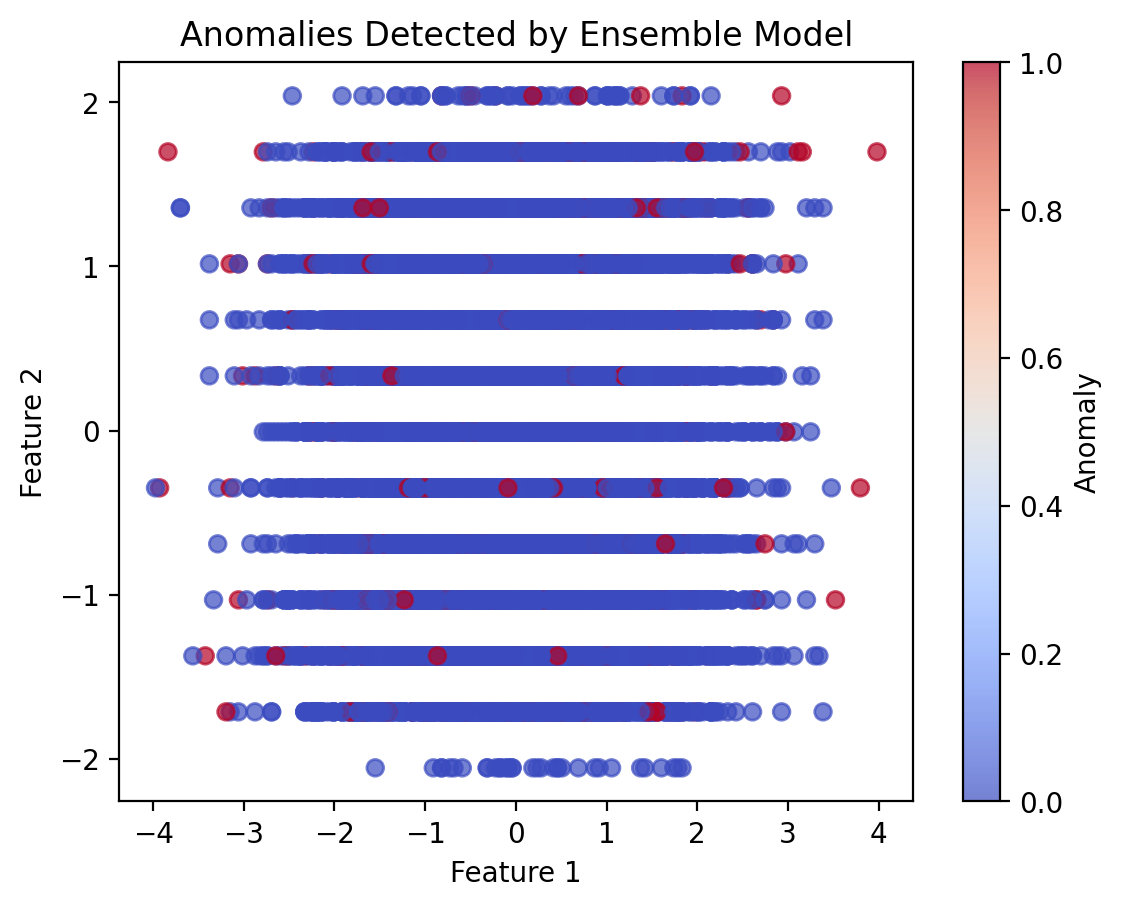

In [50]:
import matplotlib.pyplot as plt

plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=df_train['ensemble_anomaly'], cmap='coolwarm', alpha=0.7)
plt.title('Anomalies Detected by Ensemble Model')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Anomaly')
plt.show()


In [51]:
# Weighted voting example
ensemble_preds_weighted = np.round((0.5 * iso_forest_preds + 0.3 * oc_svm_preds + 0.2 * kmeans_preds)).astype(int)


North Star Metrics for Ensemble Models
Anomaly Precision and Recall (if labels are available):

Precision ensures meaningful anomalies are flagged.
Recall ensures no significant anomalies are missed.
Cluster Silhouette Score:

Measures clustering quality, even without labeled data.
Anomaly Coverage Across Clusters:

Ensures anomalies are detected across diverse operational conditions.
Reduction in False Positives:

Track false positive rates to ensure practical deployment.

# Refine Anomaly Threshold
- If anomalies seem too concentrated or sparse, refine the threshold for anomaly detection.

## Code to test different threshold

In [24]:
# Adjust the threshold to experiment with anomaly density
thresholds = [90, 95, 99]  # Percentiles
for th in thresholds:
    df_train['anomaly'] = distances > np.percentile(distances, th)
    anomaly_count = df_train['anomaly'].sum()
    print(f"Anomaly count with {th}th percentile threshold: {anomaly_count}")


Anomaly count with 90th percentile threshold: 2063
Anomaly count with 95th percentile threshold: 1032
Anomaly count with 99th percentile threshold: 207


# Visualize Feature Distributions
- To better understand how anomalies differ, visualize the distributions of key features.


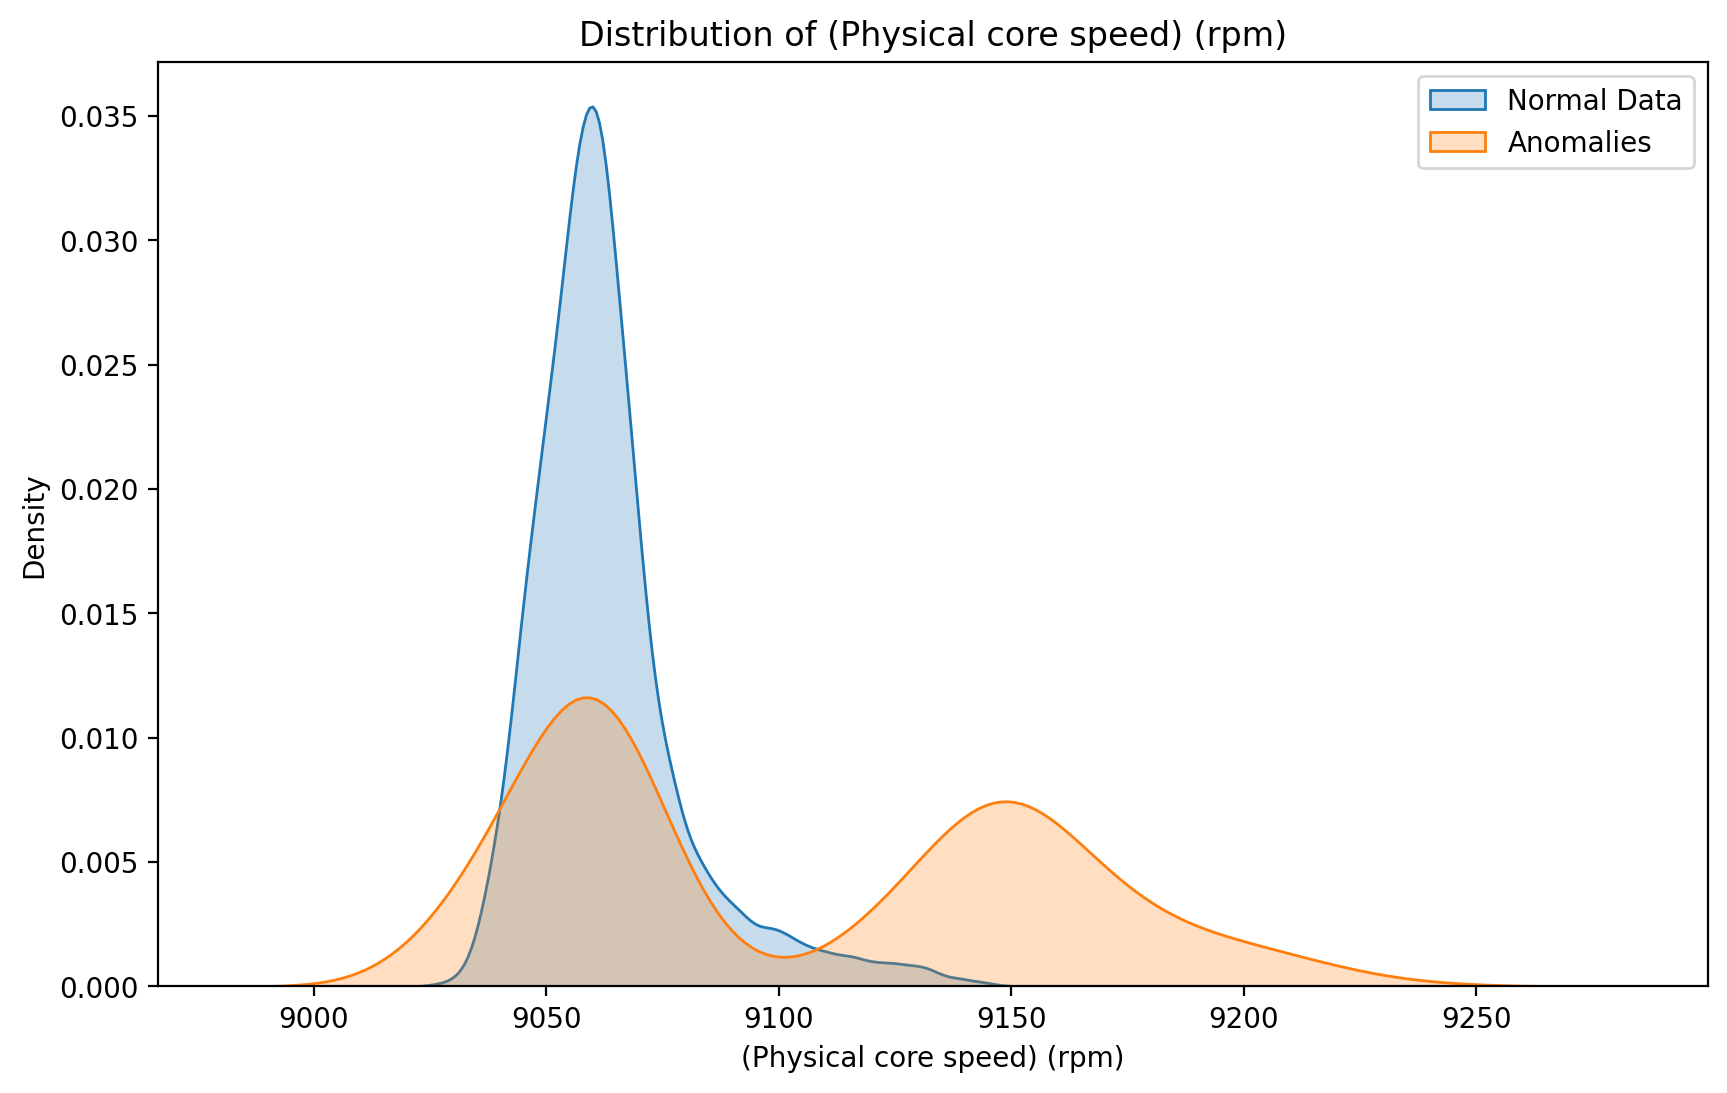

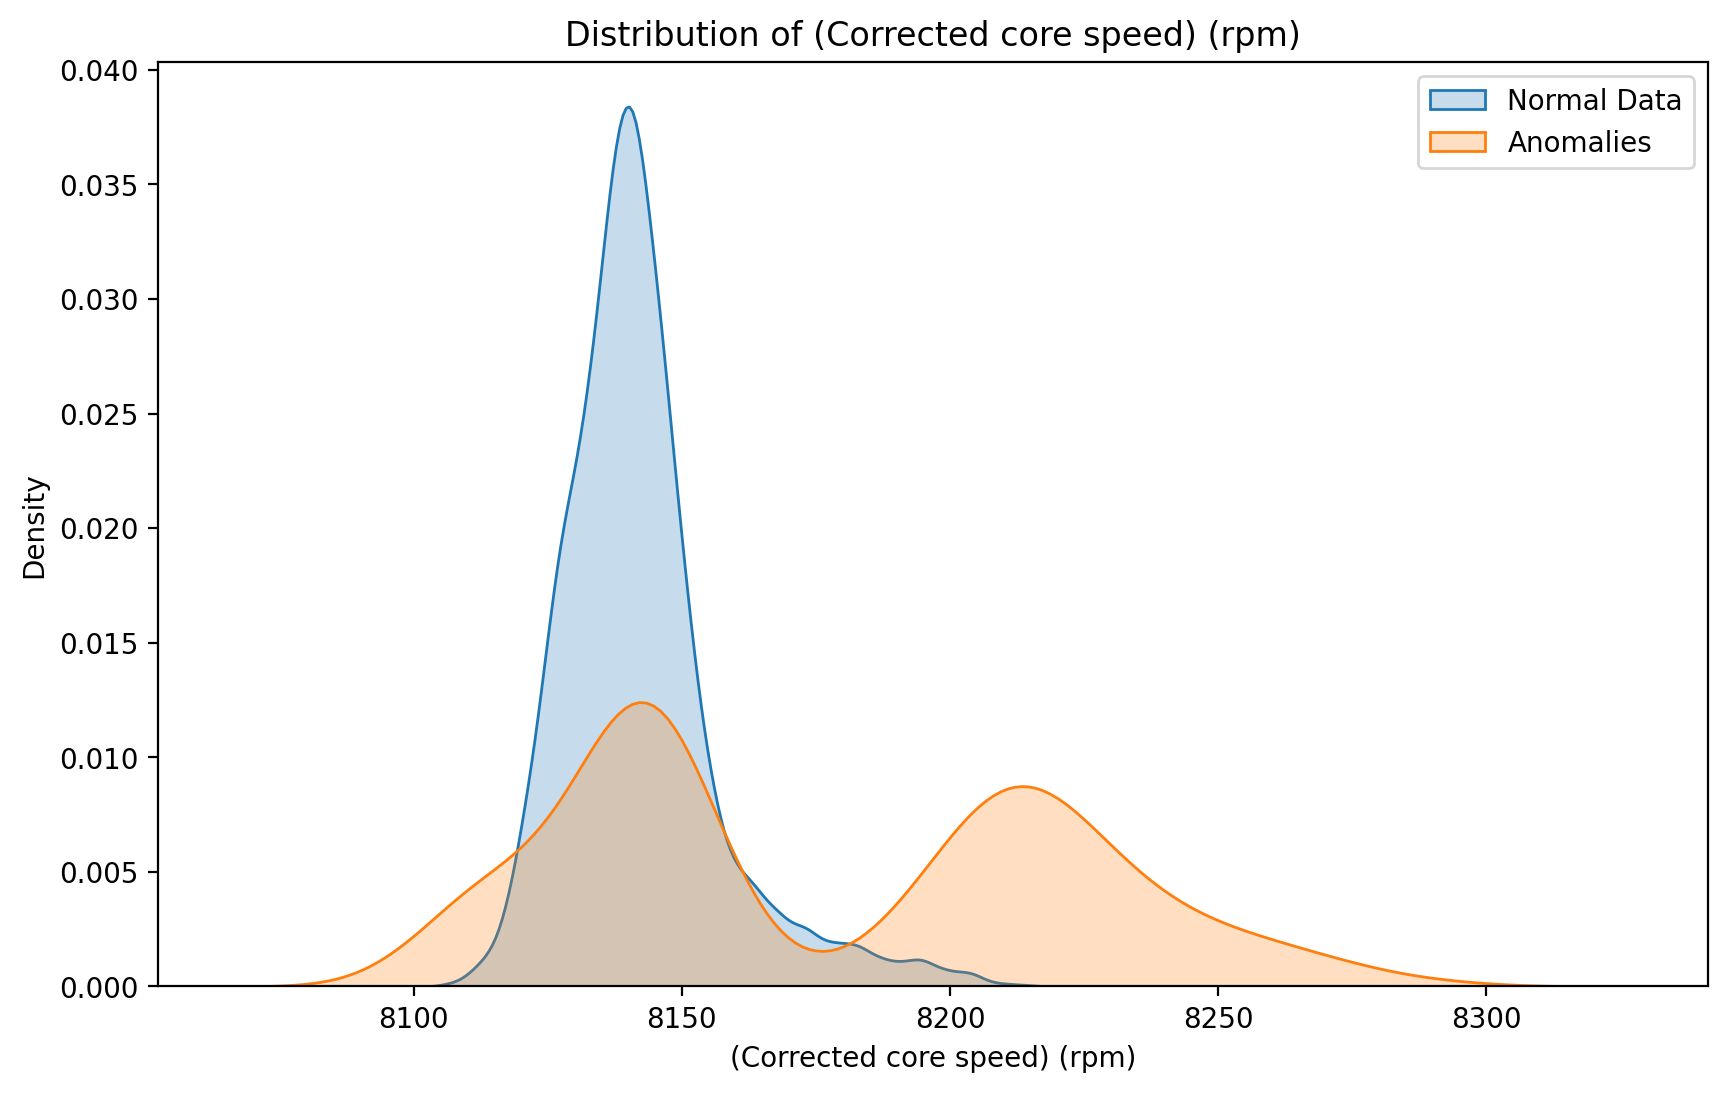

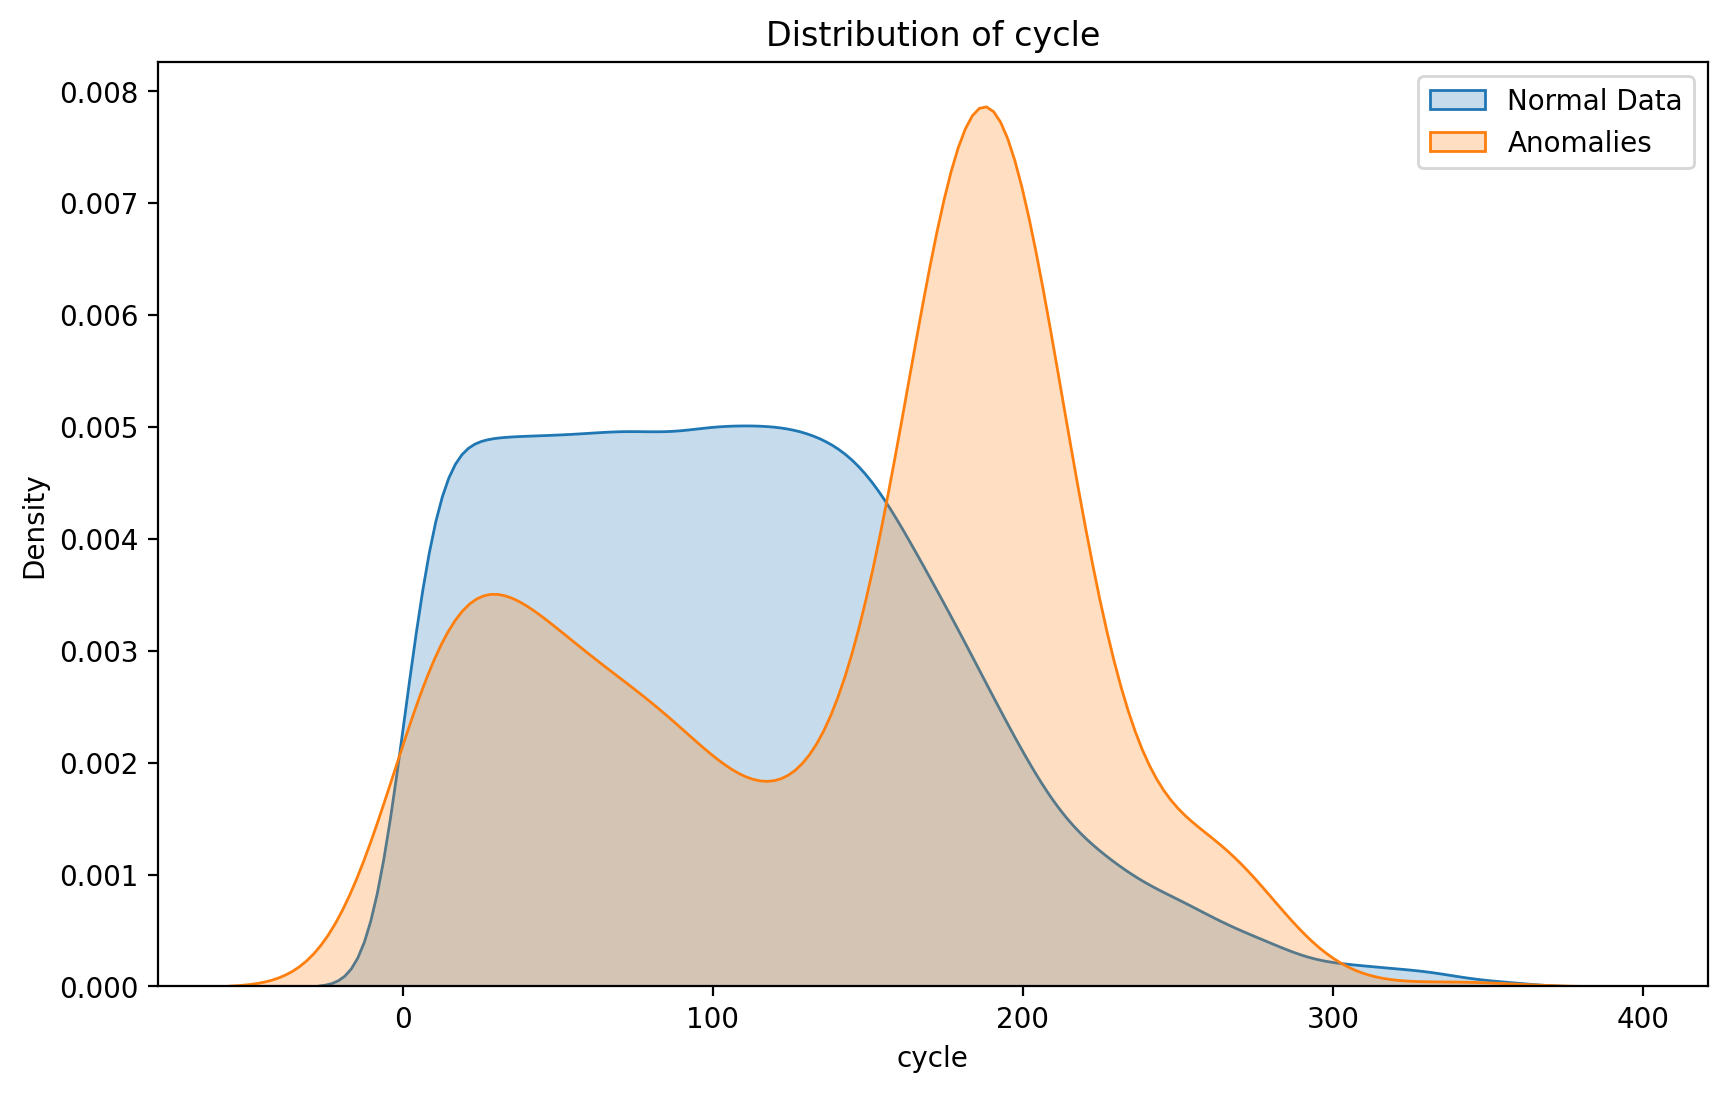

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select top 3 features with the largest differences
top_features = sorted_diff.index[:3]

# Plot distributions for each feature
for feature in top_features:
    plt.figure(figsize=(10, 6))
    sns.kdeplot(normal_data[feature], label='Normal Data', shade=True)
    sns.kdeplot(anomalies[feature], label='Anomalies', shade=True)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.legend()
    plt.show()


# To identify cluster characteristics (Normal, Degraded, Anomalous), we need to analyze the clusters' properties based on their data distributions, distance to centroids, and feature importance. 

## Step 1: Analyze Data Distribution Within Each Cluster
1. Calculate summary statistics for each feature in each cluster.
- This helps understand the typical behavior (mean/median) and variability (standard deviation) within each cluster.
- Compare cluster-level statistics to identify deviations.

In [56]:
# Add cluster labels to the dataset
df_train['cluster'] = kmeans.labels_

# Calculate summary statistics for each cluster
cluster_summary = df_train.groupby('cluster').mean()

print("Cluster Characteristics:")
print(cluster_summary)



Cluster Characteristics:
            engine       cycle  setting_1  setting_2  setting_3  (Fan inlet temperature) (◦R)  (LPC outlet temperature) (◦R)  (HPC outlet temperature) (◦R)  (LPT outlet temperature) (◦R)  (Fan inlet Pressure) (psia)  (bypass-duct pressure) (psia)  (HPC outlet pressure) (psia)  (Physical fan speed) (rpm)  (Physical core speed) (rpm)  (Engine pressure ratio(P50/P2)  (HPC outlet Static pressure) (psia)  (Ratio of fuel flow to Ps30) (pps/psia)  (Corrected fan speed) (rpm)  (Corrected core speed) (rpm)  (Bypass Ratio)   (Burner fuel-air ratio)  (Bleed Enthalpy)  (Required fan speed)  (Required fan conversion speed)  (High-pressure turbines Cool air flow)  (Low-pressure turbines Cool air flow)   anomaly  distance_to_centroid  ensemble_anomaly
cluster                                                                                                                                                                                                                             

In [68]:
from IPython.display import display

# Display the cluster summary as a table
display(cluster_summary)


,engine,cycle,setting_1,setting_2,setting_3,(Fan inlet temperature) (◦R),(LPC outlet temperature) (◦R),(HPC outlet temperature) (◦R),(LPT outlet temperature) (◦R),(Fan inlet Pressure) (psia),(bypass-duct pressure) (psia),(HPC outlet pressure) (psia),(Physical fan speed) (rpm),(Physical core speed) (rpm),(Engine pressure ratio(P50/P2),(HPC outlet Static pressure) (psia),(Ratio of fuel flow to Ps30) (pps/psia),(Corrected fan speed) (rpm),(Corrected core speed) (rpm),(Bypass Ratio),(Burner fuel-air ratio),(Bleed Enthalpy),(Required fan speed),(Required fan conversion speed),(High-pressure turbines Cool air flow),(Low-pressure turbines Cool air flow),anomaly,distance_to_centroid,ensemble_anomaly
cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,51.943683,105.727332,-0.000014,0.000005,100.0,518.67,642.732403,1590.973846,1409.933615,14.62,21.609989,553.246869,2388.111791,9059.977883,1.3,47.574205,521.309752,2388.111666,8138.710040,8.445899,0.03,393.324962,2388.0,100.0,38.797652,23.278218,0.050011,2.609463,0.005327
1,50.941736,69.552913,-0.000029,-0.000003,100.0,518.67,642.281198,1585.936327,1400.990526,14.62,21.609477,554.156990,2388.033242,9062.205047,1.3,47.297272,522.085369,2388.031881,8143.475159,8.410782,0.03,392.017175,2388.0,100.0,38.965619,23.379777,0.050073,2.768047,0.020082
2,51.572464,193.035455,0.000044,0.000007,100.0,518.67,643.341436,1598.435031,1422.113398,14.62,21.610000,552.109288,2388.184824,9083.726848,1.3,47.940282,520.344213,2388.185122,8156.300202,8.494648,0.03,395.276398,2388.0,100.0,38.568041,23.140613,0.050207,3.581112,0.142340


In [54]:
# Include standard deviation to understand variability
cluster_variability = df_train.groupby('cluster').std()

print("Cluster Variability:")
print(cluster_variability)


Cluster Variability:
            engine      cycle  setting_1  setting_2  setting_3  (Fan inlet temperature) (◦R)  (LPC outlet temperature) (◦R)  (HPC outlet temperature) (◦R)  (LPT outlet temperature) (◦R)  (Fan inlet Pressure) (psia)  (bypass-duct pressure) (psia)  (HPC outlet pressure) (psia)  (Physical fan speed) (rpm)  (Physical core speed) (rpm)  (Engine pressure ratio(P50/P2)  (HPC outlet Static pressure) (psia)  (Ratio of fuel flow to Ps30) (pps/psia)  (Corrected fan speed) (rpm)  (Corrected core speed) (rpm)  (Bypass Ratio)   (Burner fuel-air ratio)  (Bleed Enthalpy)  (Required fan speed)  (Required fan conversion speed)  (High-pressure turbines Cool air flow)  (Low-pressure turbines Cool air flow)   anomaly  distance_to_centroid  ensemble_anomaly
cluster                                                                                                                                                                                                                                  

In [69]:
from IPython.display import display

# Display the cluster summary as a table
display(cluster_variability)


,engine,cycle,setting_1,setting_2,setting_3,(Fan inlet temperature) (◦R),(LPC outlet temperature) (◦R),(HPC outlet temperature) (◦R),(LPT outlet temperature) (◦R),(Fan inlet Pressure) (psia),(bypass-duct pressure) (psia),(HPC outlet pressure) (psia),(Physical fan speed) (rpm),(Physical core speed) (rpm),(Engine pressure ratio(P50/P2),(HPC outlet Static pressure) (psia),(Ratio of fuel flow to Ps30) (pps/psia),(Corrected fan speed) (rpm),(Corrected core speed) (rpm),(Bypass Ratio),(Burner fuel-air ratio),(Bleed Enthalpy),(Required fan speed),(Required fan conversion speed),(High-pressure turbines Cool air flow),(Low-pressure turbines Cool air flow),anomaly,distance_to_centroid,ensemble_anomaly
cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,27.927680,60.150726,0.002186,0.000293,0.0,0.0,0.325203,4.168117,4.872759,0.0,0.000330,0.484525,0.041158,15.035897,0.0,0.133168,0.384031,0.041498,13.279630,0.022382,0.0,1.006756,0.0,0.0,0.111090,0.065097,0.217979,0.615367,0.072797
1,30.950882,46.496583,0.002181,0.000293,0.0,0.0,0.322080,4.197220,4.750339,0.0,0.002227,0.480040,0.038387,9.831514,0.0,0.131110,0.373634,0.039439,8.488636,0.022195,0.0,1.020778,0.0,0.0,0.109991,0.066376,0.218109,1.171724,0.140290
2,28.763515,48.483548,0.002204,0.000294,0.0,0.0,0.352995,4.533871,5.669211,0.0,0.000000,0.577775,0.061563,38.089761,0.0,0.163033,0.476151,0.062377,34.120135,0.025221,0.0,1.124735,0.0,0.0,0.123377,0.073588,0.218400,1.198016,0.349443


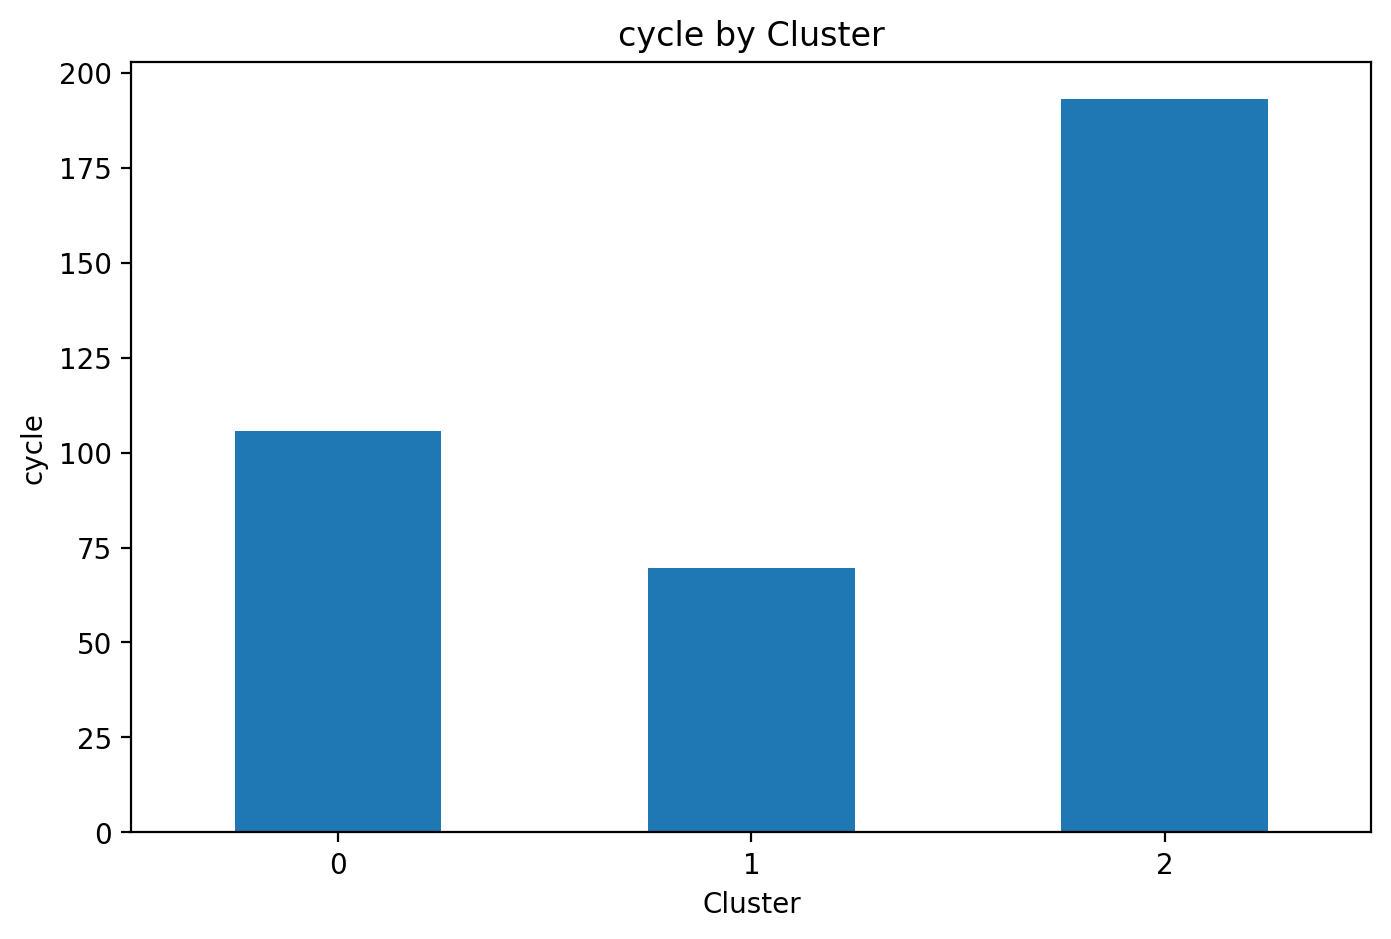

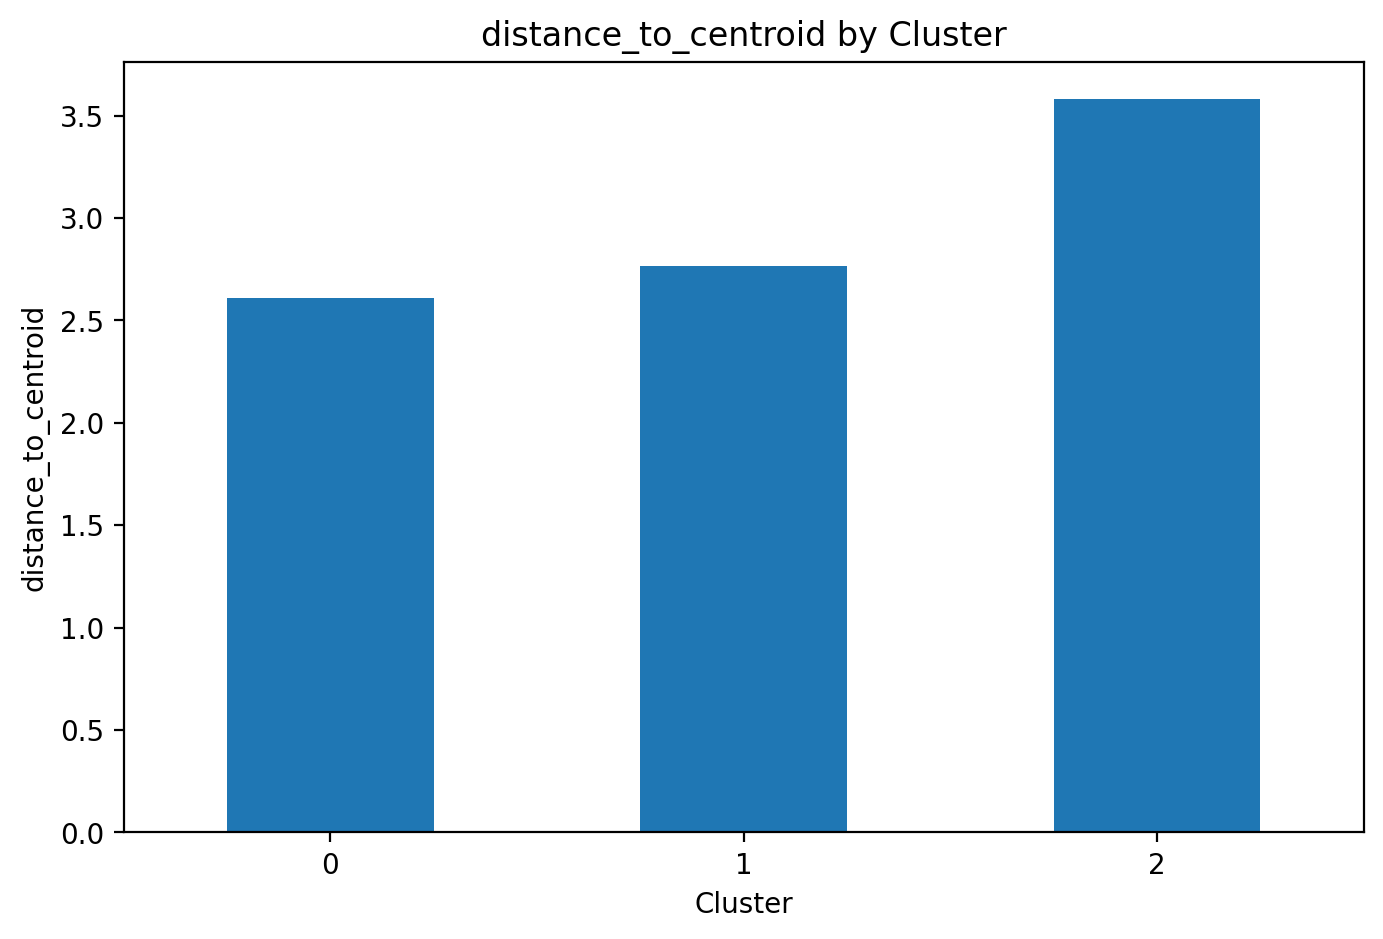

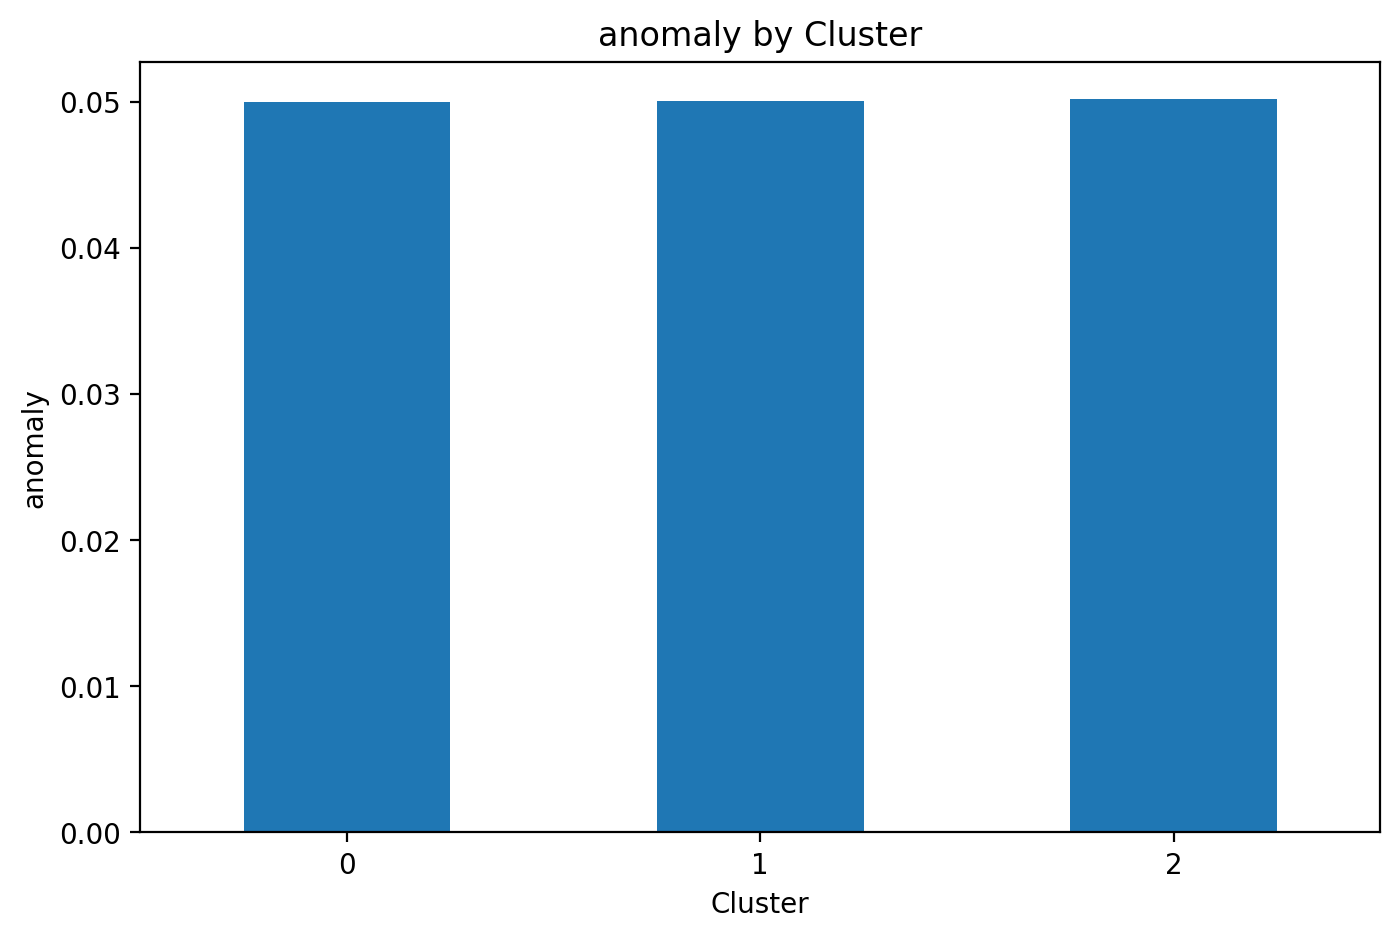

In [66]:
import matplotlib.pyplot as plt

# Plot a bar chart for selected features
features_to_plot = ['cycle', 'distance_to_centroid', 'anomaly']

for feature in features_to_plot:
    plt.figure(figsize=(8, 5))
    cluster_summary[feature].plot(kind='bar')
    plt.title(f'{feature} by Cluster')
    plt.xlabel('Cluster')
    plt.ylabel(feature)
    plt.xticks(rotation=0)
    plt.show()


,engine,cycle,setting_1,setting_2,setting_3,(Fan inlet temperature) (◦R),(LPC outlet temperature) (◦R),(HPC outlet temperature) (◦R),(LPT outlet temperature) (◦R),(Fan inlet Pressure) (psia),(bypass-duct pressure) (psia),(HPC outlet pressure) (psia),(Physical fan speed) (rpm),(Physical core speed) (rpm),(Engine pressure ratio(P50/P2),(HPC outlet Static pressure) (psia),(Ratio of fuel flow to Ps30) (pps/psia),(Corrected fan speed) (rpm),(Corrected core speed) (rpm),(Bypass Ratio),(Burner fuel-air ratio),(Bleed Enthalpy),(Required fan speed),(Required fan conversion speed),(High-pressure turbines Cool air flow),(Low-pressure turbines Cool air flow),anomaly,distance_to_centroid,ensemble_anomaly
cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,51.943683,105.727332,-0.000014,0.000005,100.0,518.67,642.732403,1590.973846,1409.933615,14.62,21.609989,553.246869,2388.111791,9059.977883,1.3,47.574205,521.309752,2388.111666,8138.710040,8.445899,0.03,393.324962,2388.0,100.0,38.797652,23.278218,0.050011,2.609463,0.005327
1,50.941736,69.552913,-0.000029,-0.000003,100.0,518.67,642.281198,1585.936327,1400.990526,14.62,21.609477,554.156990,2388.033242,9062.205047,1.3,47.297272,522.085369,2388.031881,8143.475159,8.410782,0.03,392.017175,2388.0,100.0,38.965619,23.379777,0.050073,2.768047,0.020082
2,51.572464,193.035455,0.000044,0.000007,100.0,518.67,643.341436,1598.435031,1422.113398,14.62,21.610000,552.109288,2388.184824,9083.726848,1.3,47.940282,520.344213,2388.185122,8156.300202,8.494648,0.03,395.276398,2388.0,100.0,38.568041,23.140613,0.050207,3.581112,0.142340


## Step 2: Investigate Anomalies in Each Cluster
2. Overlay anomalies (df_train['anomaly']) on the clusters to see which clusters have more anomalies:
- A high proportion of anomalies suggests a degraded or anomalous state.
- Clusters with few or no anomalies are likely normal

In [57]:
# Count anomalies per cluster
anomalies_per_cluster = df_train.groupby('cluster')['anomaly'].sum()

# Total points per cluster
total_points_per_cluster = df_train['cluster'].value_counts()

# Percentage of anomalies per cluster
anomaly_percentage = (anomalies_per_cluster / total_points_per_cluster) * 100
print("Anomaly percentage per cluster:")
print(anomaly_percentage)


Anomaly percentage per cluster:
cluster
0    5.001087
1    5.007266
2    5.020704
dtype: float64


# Step 3: Distance to Centroid Analysis
- Clusters closer to their centroids are likely Normal.
- Clusters with higher average distances to centroids are likely Degraded or Anomalous.

In [58]:
# Compute average distance to centroid for each cluster
average_distance = df_train.groupby('cluster')['distance_to_centroid'].mean()

print("Average Distance to Centroid per Cluster:")
print(average_distance)


Average Distance to Centroid per Cluster:
cluster
0    2.609463
1    2.768047
2    3.581112
Name: distance_to_centroid, dtype: float64


# Step 4: Compare Feature Distributions
Key features (e.g., temperature, pressure, RPM) can provide context:
- Features within expected ranges are Normal.
- Slight deviations indicate Degraded states.
- Extreme deviations point to Anomalous states.

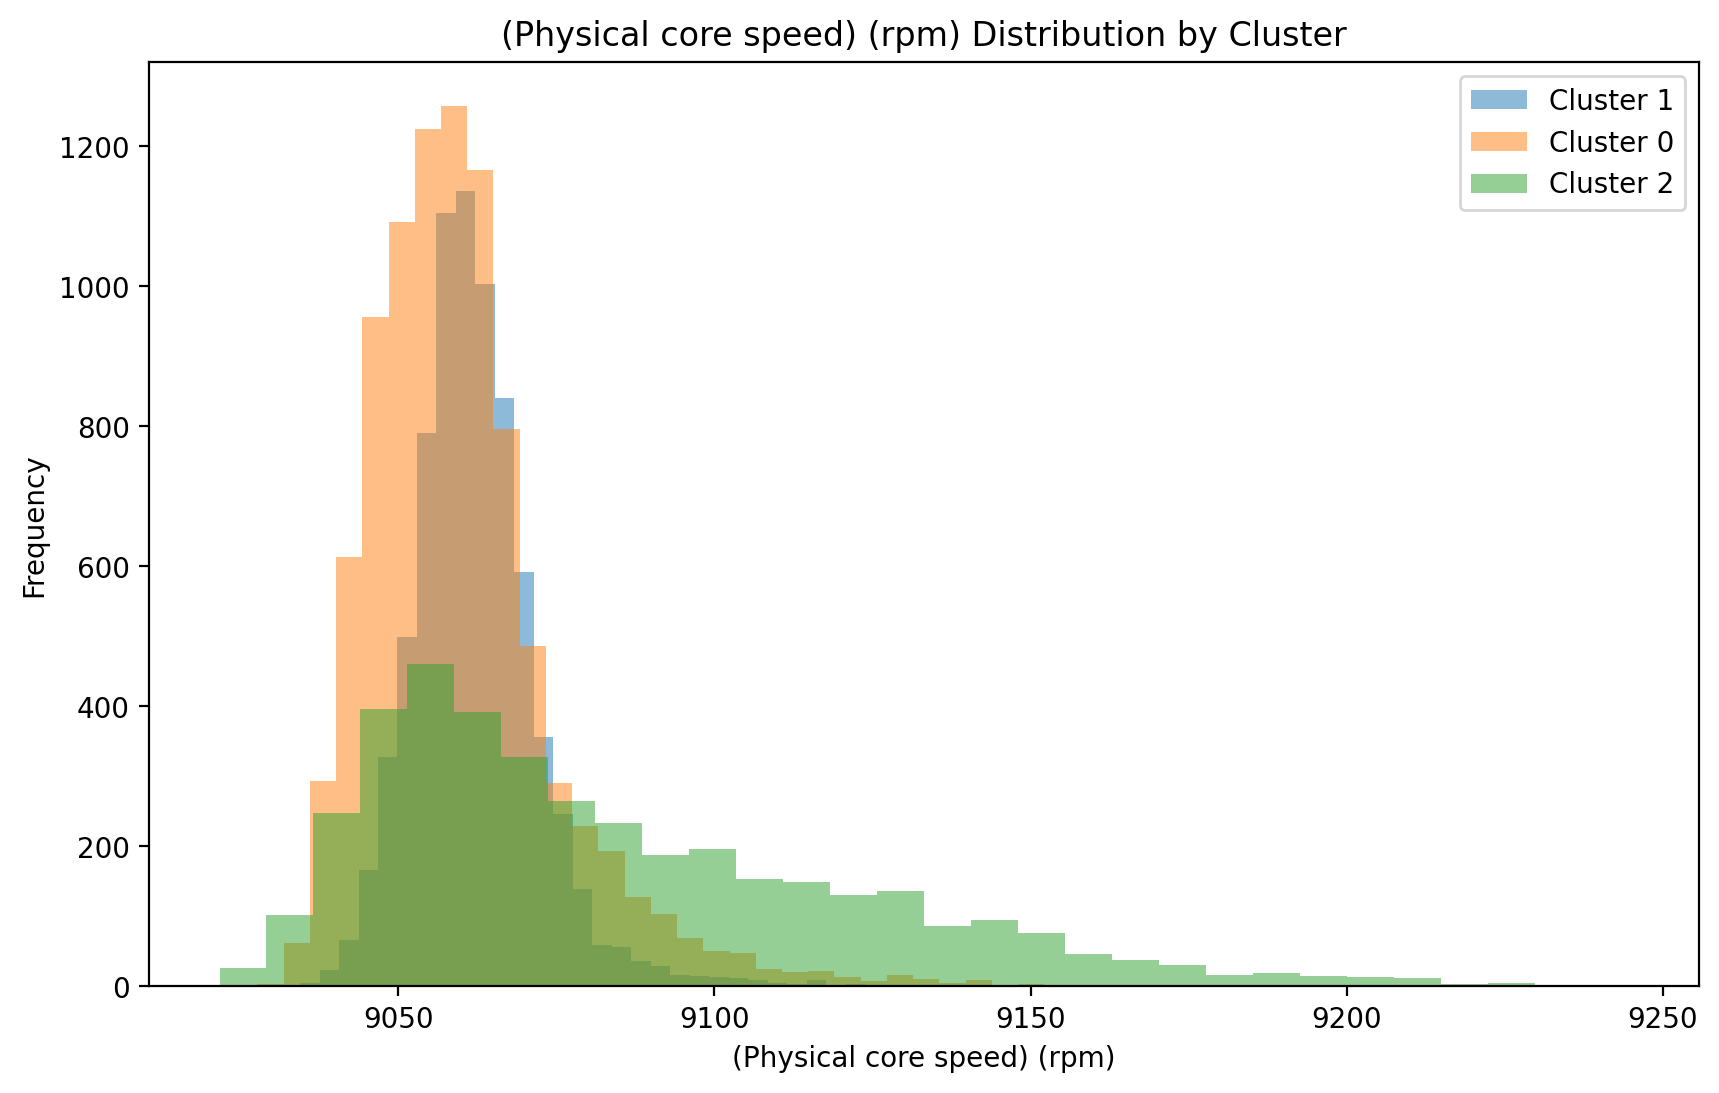

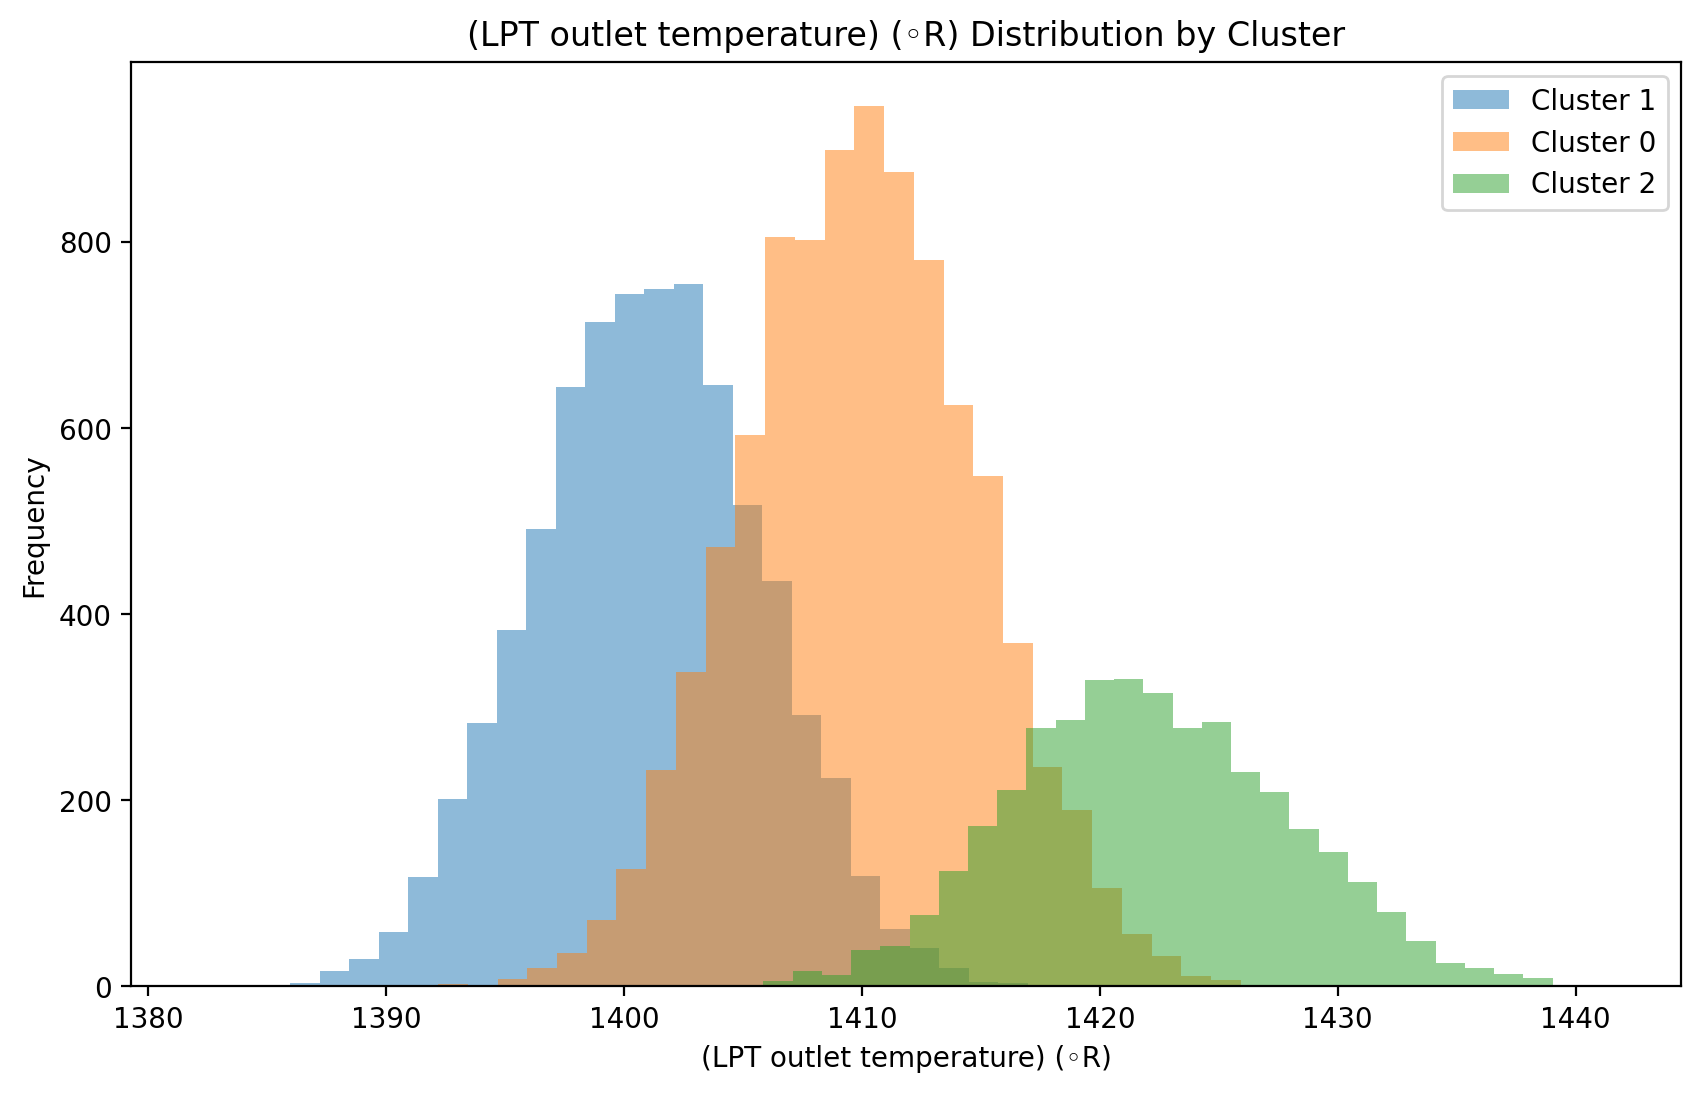

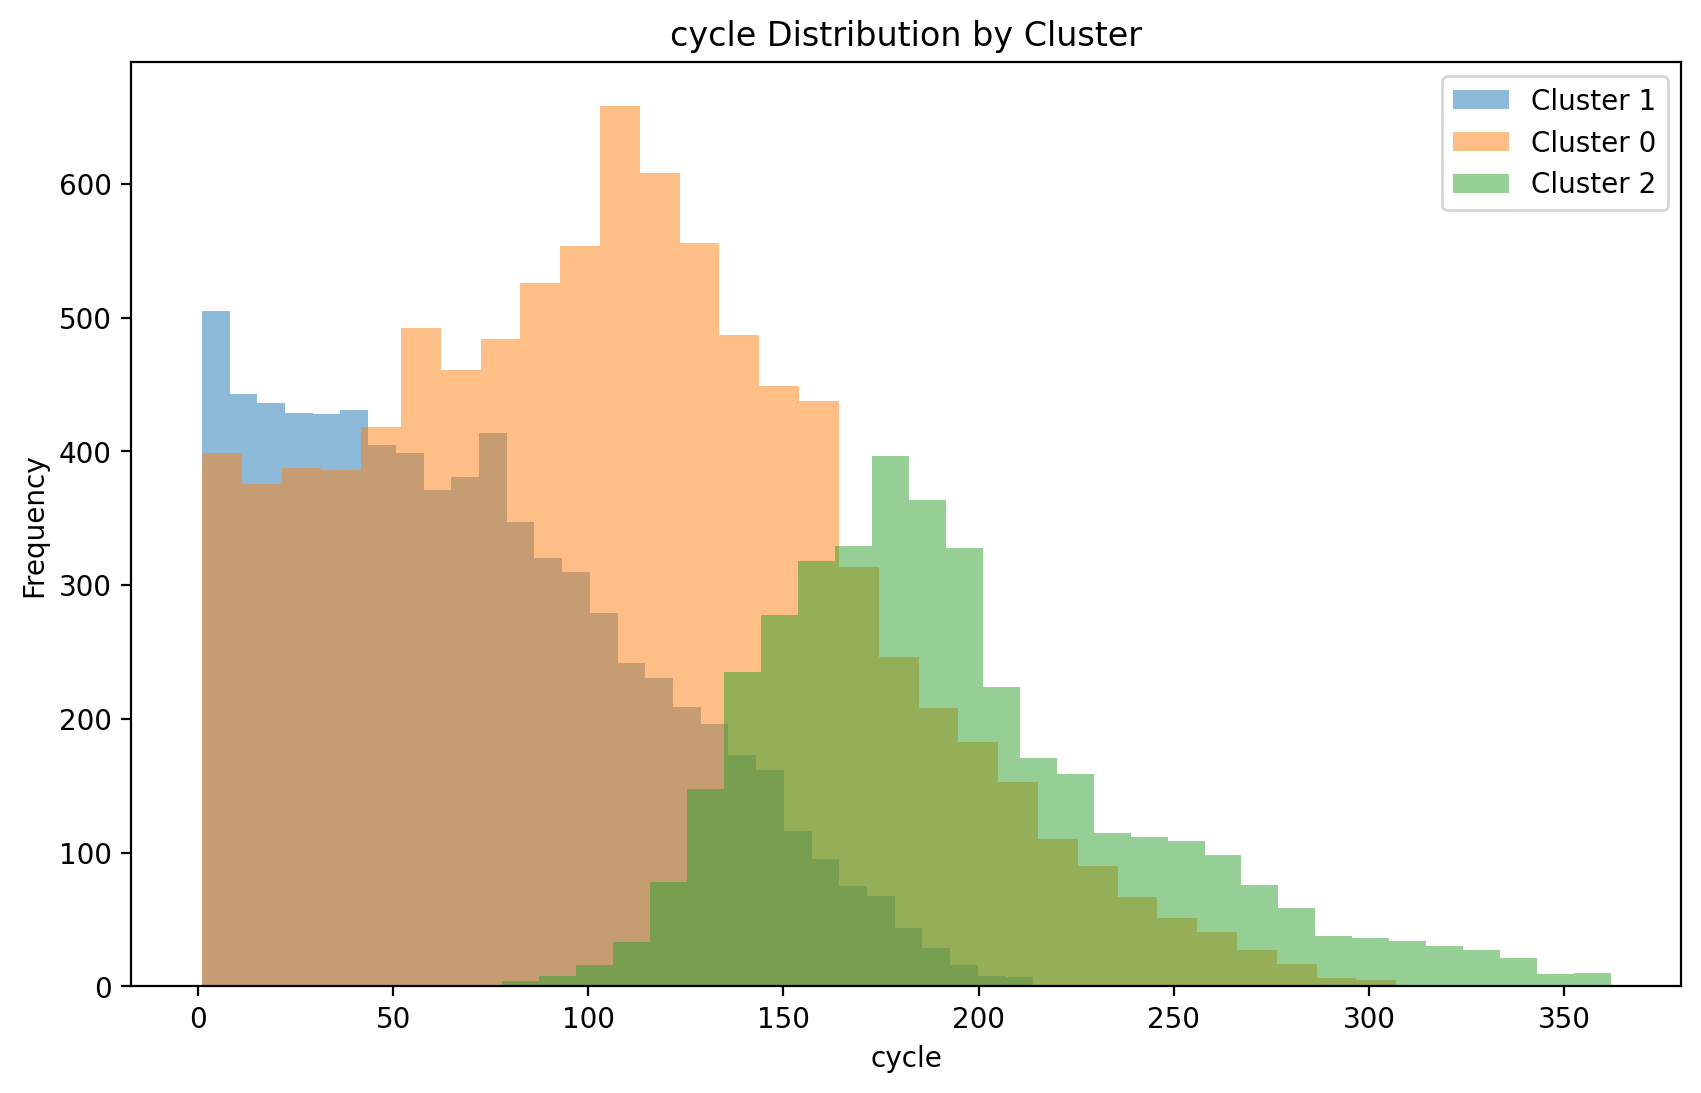

In [59]:
import matplotlib.pyplot as plt

# Plot feature distributions for each cluster
features_to_plot = ['(Physical core speed) (rpm)', '(LPT outlet temperature) (◦R)', 'cycle']

for feature in features_to_plot:
    plt.figure(figsize=(10, 6))
    for cluster in df_train['cluster'].unique():
        cluster_data = df_train[df_train['cluster'] == cluster]
        plt.hist(cluster_data[feature], bins=30, alpha=0.5, label=f'Cluster {cluster}')
    plt.title(f'{feature} Distribution by Cluster')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()


# Step 5: Label Clusters Based on Observations
Based on the analyses:

1. Normal:
- Cluster(s) with low anomaly rates.
- Data points close to centroids.
- Feature distributions align with expected ranges.
  
2. Degraded:
- Cluster(s) with moderate anomaly rates.
- Slight deviations in feature distributions.
- Higher distances to centroids compared to normal clusters.

3. Anomalous:
- Cluster(s) with high anomaly rates.
- Clear outliers in feature distributions.
- Farther from centroids.

In [61]:
# Assign labels based on observations
cluster_labels = {
    0: 'Normal',
    1: 'Degraded',
    2: 'Anomalous'
}

df_train['cluster_label'] = df_train['cluster'].map(cluster_labels)
print(df_train[['cluster', 'cluster_label']])


       cluster cluster_label
0            1      Degraded
1            1      Degraded
2            1      Degraded
3            1      Degraded
4            1      Degraded
...        ...           ...
20626        2     Anomalous
20627        2     Anomalous
20628        2     Anomalous
20629        2     Anomalous
20630        2     Anomalous

[20631 rows x 2 columns]


# Step 6: Visualize Results
- Overlay cluster labels and anomalies in a t-SNE or PCA plot to validate the categorizations.

In [63]:
from sklearn.manifold import TSNE
import pandas as pd

# Apply t-SNE to reduce dimensions to 2 for visualization
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(X_scaled)

# Add t-SNE results to the DataFrame
df_train['t-SNE Component 1'] = tsne_results[:, 0]
df_train['t-SNE Component 2'] = tsne_results[:, 1]


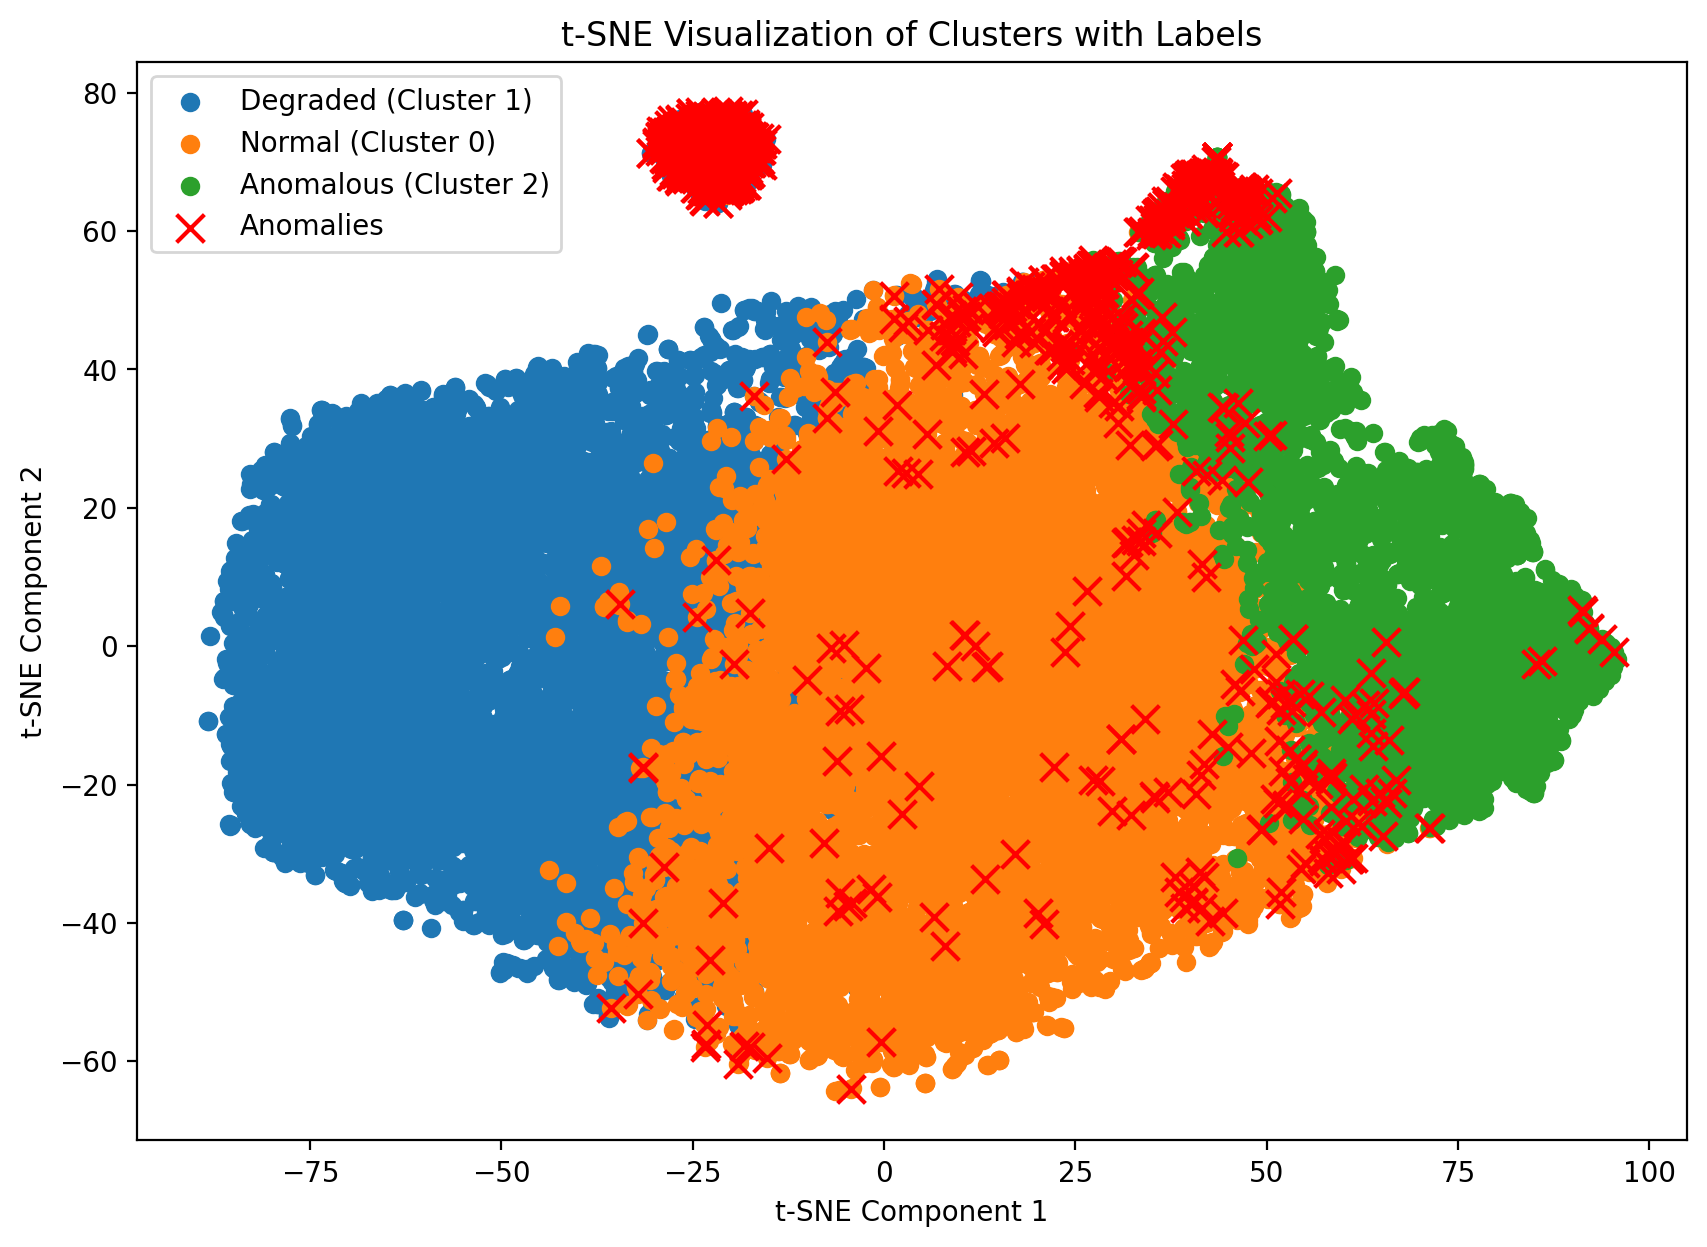

In [64]:
import matplotlib.pyplot as plt

# Plot t-SNE components and clusters
plt.figure(figsize=(10, 7))
for cluster in df_train['cluster'].unique():
    cluster_data = df_train[df_train['cluster'] == cluster]
    plt.scatter(
        cluster_data['t-SNE Component 1'], cluster_data['t-SNE Component 2'],
        label=f'{cluster_labels[cluster]} (Cluster {cluster})'
    )
    
# Highlight anomalies
anomalies = df_train[df_train['anomaly']]
plt.scatter(
    anomalies['t-SNE Component 1'], anomalies['t-SNE Component 2'],
    color='red', marker='x', s=100, label='Anomalies'
)

plt.title('t-SNE Visualization of Clusters with Labels')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.show()
